# IMPORTS

In [1]:
%tensorflow_version 2.x
import tensorflow.keras as tfk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import skimage.io
import pickle
import os
import random

from tensorflow.keras import Model, Input, layers
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score

print('TensorFlow Keras version:', tfk.__version__) # 2.2.4-tf
if os.path.exists('./sample_data'):
    !rm -r sample_data

TensorFlow Keras version: 2.3.0-tf


# DATASET LOADING

In [3]:
# LOAD ALL CLASSES IMAGES
dataset_path = './drive/My Drive/TFM/2D-Shapes-Task/Gray-Dataset/'

class_folders = []

for zip_file in os.listdir(dataset_path):
    folder_name = zip_file.split('.')[0]
    path = dataset_path.replace(' ', '\ ') + zip_file

    # !cp $path ./
    # !unzip -d ./ $zip_file
    # !rm $zip_file

    if os.path.exists(folder_name):
        !rm -r $folder_name
    !unzip -d ./ $path

    class_folders.append(folder_name)
    print('Loaded ', folder_name)

Streaming output truncated to the last 5000 lines.
 extracting: ./rectangles_gray/1430_EX2_EX3.png  
 extracting: ./rectangles_gray/2654_EX2_EX3.png  
 extracting: ./rectangles_gray/2501_EX2_EX3.png  
 extracting: ./rectangles_gray/2021_EX2_EX3.png  
 extracting: ./rectangles_gray/2835_EX2_EX3.png  
 extracting: ./rectangles_gray/1799_EX2_EX3.png  
 extracting: ./rectangles_gray/2169_EX2_EX3.png  
 extracting: ./rectangles_gray/1831_EX2_EX3.png  
 extracting: ./rectangles_gray/2237_EX2_EX3.png  
 extracting: ./rectangles_gray/1011_EX2_EX3.png  
 extracting: ./rectangles_gray/1870_EX2_EX3.png  
 extracting: ./rectangles_gray/1689_EX2_EX3.png  
 extracting: ./rectangles_gray/2173_EX2_EX3.png  
 extracting: ./rectangles_gray/2688_EX2_EX3.png  
 extracting: ./rectangles_gray/2362_EX2_EX3.png  
 extracting: ./rectangles_gray/118_EX2_EX3.png  
 extracting: ./rectangles_gray/979_EX2_EX3.png  
 extracting: ./rectangles_gray/773_EX2_EX3.png  
  inflating: ./rectangles_gray/1227_EX2_EX3.png  
 e

# DATASET PREPROCESSING

In [0]:
def load_setex_dataset(class_folders):
    X, Y, Y_expl = [], [], []
    
    for class_folder in class_folders:
        main_label = class_folder.split('_')[0]
        main_label = main_label[:-1]
        print('Preprocessing class', main_label, '...')

        for img_file in os.listdir(class_folder):
            path = './'+class_folder+'/'+img_file
            
            expl_labels = img_file.split('.')[0]
            expl_labels = expl_labels.split('_')[1:]
            # print(expl_labels)

            img = skimage.io.imread(path)
            # print(img.dtype, img.max(), img.min())

            X.append(img)
            Y.append(main_label)
            Y_expl.append(expl_labels)

    X = np.array(X, dtype='float') / 255.0
    if len(img.shape)==2: X = np.expand_dims(X, axis=-1)
    Y = np.array(Y)
    Y_expl = np.array(Y_expl)

    return X, Y, Y_expl

def binarize_all_labels(Y, Y_expl, lb_save_path=None, mlb_save_path=None):

    if lb_save_path is not None and os.path.exists(lb_save_path):
        lb = pickle.loads( open(lb_save_path, 'rb').read() )
        print('Main labels binarizer loaded from file')
        Y = lb.transform(Y)
    else:
        lb = LabelBinarizer()
        print('Binarizing main labels ...')
        Y = lb.fit_transform(Y)
        if lb_save_path:
            print('Storing main label binarizer to file ...')
            with open(lb_save_path, 'wb') as f:
                f.write(pickle.dumps(lb))

    if mlb_save_path is not None and os.path.exists(mlb_save_path):
        mlb = pickle.loads( open(mlb_save_path, 'rb').read() )
        print('Explanations label binarizer loaded from file')
        Y_expl = mlb.transform(Y_expl)
    else:
        mlb = MultiLabelBinarizer()
        print('Binarizing explanations labels ...')
        Y_expl = mlb.fit_transform(Y_expl)
        if mlb_save_path:
            print('Storing explanations label binarizer to file ...')
            with open(mlb_save_path, 'wb') as f:
                f.write(pickle.dumps(mlb))

    return Y, Y_expl, lb, mlb

In [35]:
%%time
# LOAD ALL IMAGES AND THEIR LABELS
X, Y, Y_expl = load_setex_dataset(class_folders)
Y, Y_expl, lb, mlb = binarize_all_labels(Y, Y_expl, lb_save_path='./drive/My Drive/TFM/2D-Shapes-Task/Gray-Model/Trained-Models/lb.pickle', mlb_save_path='./drive/My Drive/TFM/2D-Shapes-Task/Gray-Model/Trained-Models/mlb.pickle')

num_main_classes = len(lb.classes_)
num_expl_classes = len(mlb.classes_)
lb.classes_, mlb.classes_

Preprocessing class triangle ...
Preprocessing class square ...
Preprocessing class rectangle ...
Preprocessing class circle ...
Binarizing main labels ...
Storing main label binarizer to file ...
Binarizing explanations labels ...
Storing explanations label binarizer to file ...
CPU times: user 3.22 s, sys: 227 ms, total: 3.44 s
Wall time: 3.45 s


## DATASET SPLITTING

In [0]:
def train_test_setex_split(X, Y, Y_expl, val_size, random_state=None):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
    train_idxs, val_idxs = next(sss.split(X, Y))
    return X[train_idxs], X[val_idxs], Y[train_idxs], Y[val_idxs], Y_expl[train_idxs], Y_expl[val_idxs]

In [37]:
%time
random_state=42
X_train, X_val, Y_train, Y_val, Y_expl_train, Y_expl_val = train_test_setex_split(X, Y, Y_expl, val_size=0.5, random_state=random_state)
X_train.shape, X_val.shape

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


((6000, 64, 64, 1), (6000, 64, 64, 1))

In [38]:
Y_train[10], Y_expl_train[10]

(array([1, 0, 0, 0]), array([1, 0, 0, 0, 0]))

# MODEL DEFINITION

In [0]:
class Mirror_SetEx_Handler():

    def __init__(self, input_shape, num_main_classes, num_expl_classes, main_filters, expl_filters,
                 main_dropout = 0, expl_dropout = 0, main_kernel_size = 4, expl_kernel_size = 4, main_padding = 'same', expl_padding = 'same'):
        assert len(main_filters) == len(expl_filters),'Number of layers in both models must be equal'
        # assert np.sum([main_filters[i]==expl_filters[i] for i in range(len(main_filters))]) == len(main_filters), 'All filters must be equal'

        self.input_shape = input_shape
        self.num_main_classes = num_main_classes
        self.num_expl_classes = num_expl_classes
        self.main_filters = main_filters
        self.expl_filters = expl_filters
        self.main_kernel_size = main_kernel_size
        self.expl_kernel_size = expl_kernel_size
        self.main_dropout = main_dropout
        self.main_padding = main_padding
        self.expl_padding = expl_padding
        self.expl_dropout = expl_dropout
        
        self.main_model = None # Main classification model
        self.expl_model = None # Explanations model
        self.setex_model = None # Entire model (outputs main class and explanations)

    # def build_main_model(self):
    #     input = Input(self.input_shape, name='Input_layer')

    #     first_layer = True
    #     for i in range(len(self.main_filters)):
    #         filters = self.main_filters[i]

    #         if first_layer: 
    #             x = layers.Conv2D(filters, self.main_kernel_size, padding=self.main_padding, activation='relu', name='Conv2d_layer_'+str(i))(input)
    #             first_layer = False
    #         else:
    #             x = layers.Conv2D(filters, self.main_kernel_size, padding=self.main_padding, activation='relu', name='Conv2d_layer_'+str(i))(x)
    #         x = layers.BatchNormalization(name='BatchNorm_layer_'+str(i))(x)
    #         x = layers.MaxPool2D(name='MaxPool_layer_'+str(i))(x)

    #     x = layers.Flatten(name='Flatten_layer')(x)
    #     if self.main_dropout > 0:
    #         x = layers.Dropout(self.main_dropout, name='Dropout_layer')(x)
        
    #     y = layers.Dense(self.num_main_classes, activation='softmax')(x)

    #     self.main_model = Model(inputs=input, outputs=y)
    #     return self.main_model

    def build_setex_model(self):
        hidden_outputs = []
        ##################### MAIN MODEL ############################
        input_main = Input(self.input_shape, name='Input_layer')
        first_layer = True
        for i in range(len(self.main_filters)):
            filters = self.main_filters[i]

            if first_layer:
                x_main = layers.Conv2D(filters, self.main_kernel_size, padding=self.main_padding, activation='relu', name='Main_Conv_'+str(i))(input_main)
                first_layer = False
            else:
                x_main = layers.Conv2D(filters, self.main_kernel_size, padding=self.main_padding, activation='relu', name='Main_Conv_'+str(i))(x_main)
            x_main = layers.BatchNormalization(name='Main_BatchNorm_'+str(i))(x_main)
            x_main = layers.MaxPool2D(name='Main_MaxPool_'+str(i))(x_main)

            hidden_outputs.append(x_main)

        x_main = layers.Flatten(name='Main_Flatten')(x_main)
        if self.main_dropout > 0:
            x_main = layers.Dropout(self.main_dropout, name='Main_Dropout')(x_main)
        
        y_main = layers.Dense(self.num_main_classes,name='Main_Dense', activation='softmax')(x_main)
        self.main_model = Model(inputs=input_main, outputs=y_main, name='Main_Model')


        ###################### EXPL MODEL #############################
        input_expl = hidden_outputs[0]
        first_layer = True
        for i in range(len(self.expl_filters)):
            filters = self.expl_filters[i]

            if first_layer: 
                x_expl = layers.Conv2D(filters, self.expl_kernel_size, padding=self.expl_padding, activation='relu', name='Expl_Conv_'+str(i))(input_expl)
                first_layer = False
            else:
                x_concat = hidden_outputs[i]
                x_expl = layers.concatenate([x_expl, x_concat], axis=-1, name='Expl_Concat_'+str(i-1))
                x_expl = layers.Conv2D(filters, self.expl_kernel_size, padding=self.expl_padding, activation='relu', name='Expl_Conv_'+str(i))(x_expl)
            x_expl = layers.BatchNormalization(name='Expl_BatchNorm_'+str(i))(x_expl)
            x_expl = layers.MaxPool2D(name='Expl_MaxPool_'+str(i))(x_expl)

        x_expl = layers.Flatten(name='Expl_Flatten')(x_expl)
        if self.expl_dropout > 0:
            x_expl = layers.Dropout(self.expl_dropout, name='Expl_Dropout')(x_expl)
        
        y_expl = layers.Dense(self.num_expl_classes, name='Expl_Dense', activation='sigmoid')(x_expl)
        self.expl_model = Model(inputs=input_main, outputs=y_expl, name='Expl_Model')


        ####################### SETEX MODEL ##############################
        self.setex_model = Model(inputs=input_main, outputs=[self.main_model(input_main), self.expl_model(input_main)], name='Setex_Model')

    def prepare_main_training(self):
        for layer in self.main_model.layers:
            if 'Main' in layer.name:
                layer.trainable = True
        print('Main layers enabled for training')

    def prepare_expl_training(self):
        for layer in self.expl_model.layers:
            if 'Main' in layer.name:
                layer.trainable = False
        print('Main layers disabled for training')

    def prepare_setex_training(self):
        for layer in self.setex_model.layers:
            layer.trainable = True
        print('All layers enabled for training')


## MODEL BUILDING

In [0]:
input_shape = X[0].shape

main_filters = [5, 5, 5]
main_padding = 'valid'
main_dropout = 0
main_kernel_size = 4

expl_filters = [3, 3, 3]
expl_padding = 'valid'
expl_dropout = 0
expl_kernel_size = 4

##################################################

mirror_setex_hdl = Mirror_SetEx_Handler(input_shape, num_main_classes=num_main_classes, num_expl_classes=num_expl_classes, main_filters=main_filters, expl_filters=expl_filters,
                          main_padding=main_padding, expl_padding=expl_padding, main_dropout=main_dropout, expl_dropout=expl_dropout, main_kernel_size=main_kernel_size, expl_kernel_size=expl_kernel_size)
# main_model = mirror_setex_hdl.build_main_model()
mirror_setex_hdl.build_setex_model()

main_model, expl_model, setex_model = mirror_setex_hdl.main_model, mirror_setex_hdl.expl_model, mirror_setex_hdl.setex_model

In [41]:
setex_model.summary()

Model: "Setex_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer (InputLayer)        [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
Main_Model (Model)              (None, 4)            1459        Input_layer[0][0]                
__________________________________________________________________________________________________
Expl_Model (Model)              (None, 5)            2028        Input_layer[0][0]                
Total params: 2,532
Trainable params: 2,484
Non-trainable params: 48
__________________________________________________________________________________________________


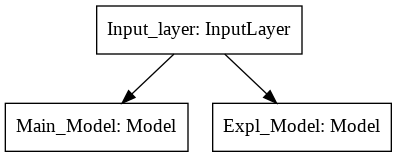

In [42]:
tfk.utils.plot_model(setex_model)

# MAIN TASK TRAINING

In [0]:
epochs = 250
lr = 1e-3
lr_decay = lr/epochs
batch_size = 64
optimizer = tfk.optimizers.Nadam(lr, decay=lr_decay)
steps_per_epoch = int(X_train.shape[0]/batch_size)

main_model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
%%time
mcp_save = tfk.callbacks.ModelCheckpoint('./best_main_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
main_hist = main_model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_val, Y_val), steps_per_epoch=steps_per_epoch, epochs=epochs, callbacks=[mcp_save])

Epoch 1/250
93/93 [==============================] - 1s 10ms/step - loss: 1.2070 - accuracy: 0.5430 - val_loss: 1.4259 - val_accuracy: 0.3355
Epoch 2/250
93/93 [==============================] - 1s 9ms/step - loss: 0.6272 - accuracy: 0.7761 - val_loss: 1.3597 - val_accuracy: 0.4295
Epoch 3/250
93/93 [==============================] - 1s 9ms/step - loss: 0.4351 - accuracy: 0.8582 - val_loss: 1.1981 - val_accuracy: 0.4930
Epoch 4/250
93/93 [==============================] - 1s 9ms/step - loss: 0.3200 - accuracy: 0.8989 - val_loss: 0.9210 - val_accuracy: 0.6223
Epoch 5/250
93/93 [==============================] - 1s 9ms/step - loss: 0.2448 - accuracy: 0.9259 - val_loss: 0.5961 - val_accuracy: 0.8090
Epoch 6/250
93/93 [==============================] - 1s 9ms/step - loss: 0.1941 - accuracy: 0.9434 - val_loss: 0.3739 - val_accuracy: 0.8865
Epoch 7/250
93/93 [==============================] - 1s 9ms/step - loss: 0.1576 - accuracy: 0.9540 - val_loss: 0.2565 - val_accuracy: 0.9292
Epoch 8/250


## EVALUATION

In [0]:
def show_main_mistake_k(k, X, Y_classes, Y_pred_classes, incorrect_preds, prob_preds=None):
    # incorrect_preds = np.where(Y_classes != Y_pred_classes)[0]
    # print(incorrect_preds)
    # print(Y_classes[incorrect_preds])
    # print(Y_pred_classes[incorrect_preds])

    # print('A total of',len(incorrect_preds),'mistakes found')

    index = incorrect_preds[min(k, incorrect_preds.shape[0]-1)]
    mistake_img, true_label, pred_label = X[index], Y_classes[index], Y_pred_classes[index]

    print('True class:', lb.classes_[true_label])
    print('Predicted class:', lb.classes_[pred_label])

    if prob_preds is not None:
        mistake_probs = prob_preds[index]

        fig, axis = plt.subplots(1, 2, figsize=(10, 5))
        if mistake_img.shape[-1]==1:
            axis[0].imshow(np.squeeze(mistake_img), cmap='gray')
        else: axis[0].imshow(mistake_img)
        axis[1].bar(x=lb.classes_, height=mistake_probs, color=['r' if i != true_label else 'g' for i in range(len(lb.classes_))])
        plt.show()
    else:
        fig, axis = plt.subplots(1, 1, figsize=(5, 5))
        if mistake_img.shape[-1]==1: axis.imshow(np.squeeze(mistake_img), cmap='gray')
        else: axis[0].imshow(mistake_img)
        plt.show()

def visualize_conv_layers(model, filters):
    conv_layers = [layer for layer in model.layers if 'Conv' in layer.name]
    for i in range(len(filters)):
        num_filters = filters[i]
        kernels, biases = conv_layers[i].get_weights()
        
        fig, axis = plt.subplots(1, num_filters)
        for j in range(num_filters):
            # plt.imshow( np.squeeze( np.mean(kernels[:,:,:,j], axis=-1) ), cmap='gray' )
            # plt.show()
            axis[j].imshow( np.squeeze( np.mean(kernels[:,:,:,j], axis=-1) ), cmap='gray' )
        
        print('Layer number',i,'with',num_filters,'filters')
        plt.show()

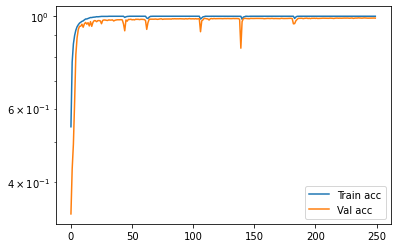

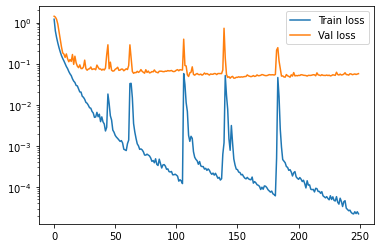

Minimum loss on training: 2.2164227630128153e-05 at epoch: 246
Minimum loss on validation: 0.044320881366729736 at epoch: 145
Maximum acc on training: 1.0 at epoch: 34
Maximum acc on validation: 0.9909999966621399 at epoch: 236
188/188 [==============================] - 0s 2ms/step - loss: 0.0531 - accuracy: 0.9910
Val score of best saved model: 0.9909999966621399
188/188 [==============================] - 0s 2ms/step - loss: 2.8155e-05 - accuracy: 1.0000
Train score of best saved model: 1.0


In [46]:
plt.plot(main_hist.history['accuracy'], label='Train acc')
plt.plot(main_hist.history['val_accuracy'], label='Val acc')
plt.legend()
plt.yscale('log')
plt.show()

plt.plot(main_hist.history['loss'], label='Train loss')
plt.plot(main_hist.history['val_loss'], label='Val loss')
plt.legend()
plt.yscale('log')
plt.show()

print('Minimum loss on training:', np.min(main_hist.history['loss']),'at epoch:', np.argmin(main_hist.history['loss'])+1)
print('Minimum loss on validation:', np.min(main_hist.history['val_loss']),'at epoch:', np.argmin(main_hist.history['val_loss'])+1)
print('Maximum acc on training:', np.max(main_hist.history['accuracy']),'at epoch:', np.argmax(main_hist.history['accuracy'])+1)
print('Maximum acc on validation:', np.max(main_hist.history['val_accuracy']),'at epoch:', np.argmax(main_hist.history['val_accuracy'])+1)

main_model = tfk.models.load_model('./best_main_model.h5')
best_val_acc = main_model.evaluate(X_val, Y_val)[1]
print('Val score of best saved model:', best_val_acc)
best_train_acc = main_model.evaluate(X_train, Y_train)[1]
print('Train score of best saved model:', best_train_acc)

In [47]:
main_pred_prob = main_model.predict(X_val)
Y_val_classes, Y_val_pred_class = Y_val.argmax(axis=1), main_pred_prob.argmax(axis=1)
main_incorrect_preds = np.where(Y_val_classes != Y_val_pred_class)[0]

matrix = confusion_matrix(Y_val_classes, Y_val_pred_class).T
print(lb.classes_)
print(matrix)
print('A total of',len(main_incorrect_preds),'mistakes found out of',X_val.shape[0])

['circle' 'rectangle' 'square' 'triangle']
[[1500    1    0    0]
 [   0 1466    1   19]
 [   0   31 1499    0]
 [   0    2    0 1481]]
A total of 54 mistakes found out of 6000


True class: triangle
Predicted class: rectangle


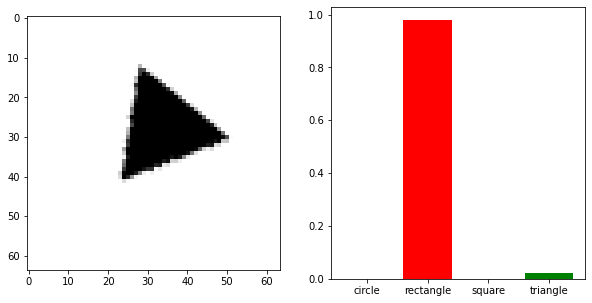

True class: rectangle
Predicted class: square


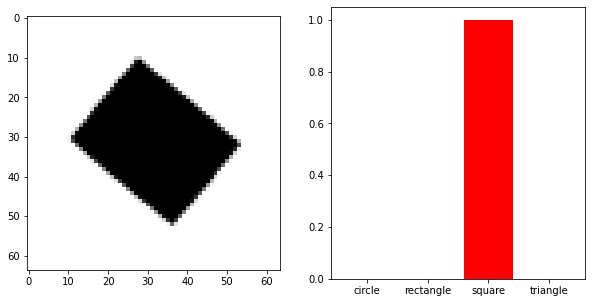

True class: rectangle
Predicted class: square


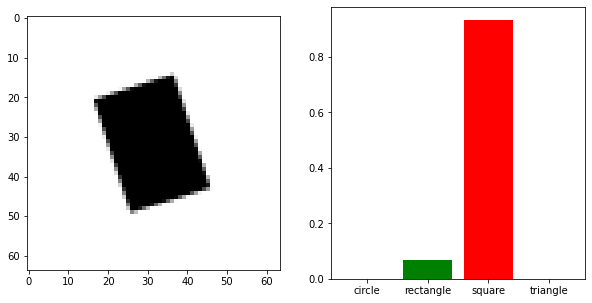

True class: rectangle
Predicted class: square


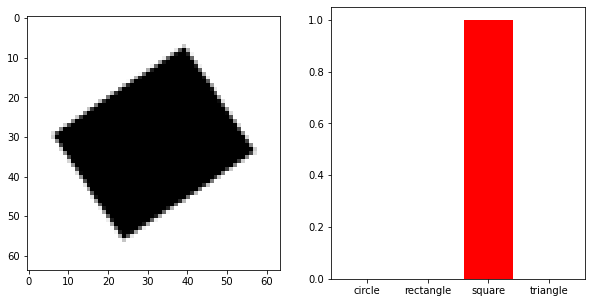

True class: rectangle
Predicted class: square


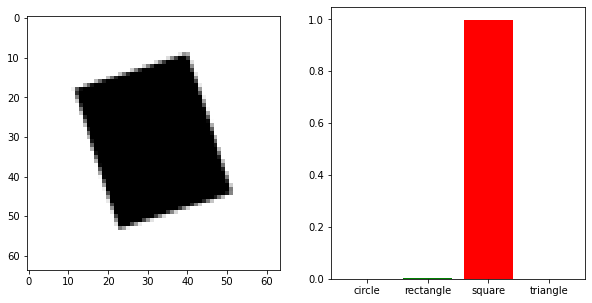

True class: triangle
Predicted class: rectangle


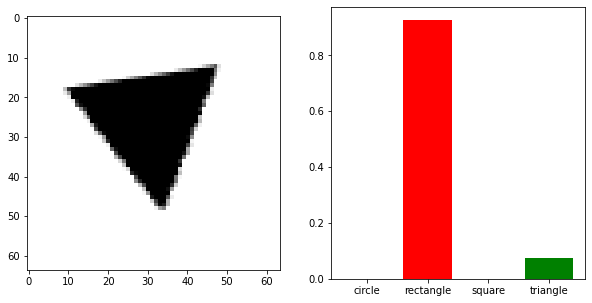

True class: rectangle
Predicted class: square


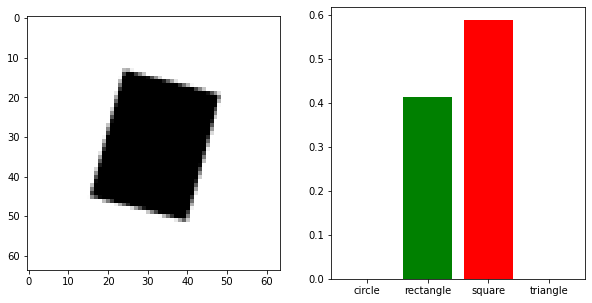

True class: rectangle
Predicted class: square


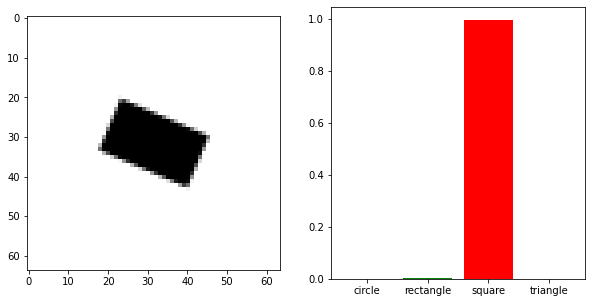

True class: rectangle
Predicted class: square


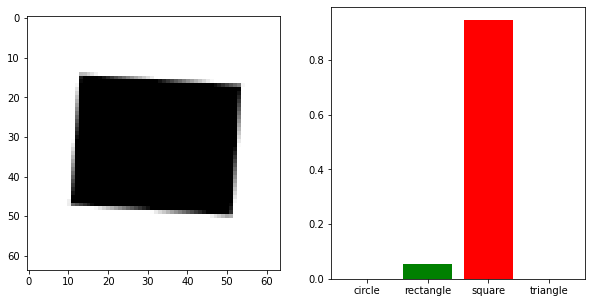

True class: rectangle
Predicted class: square


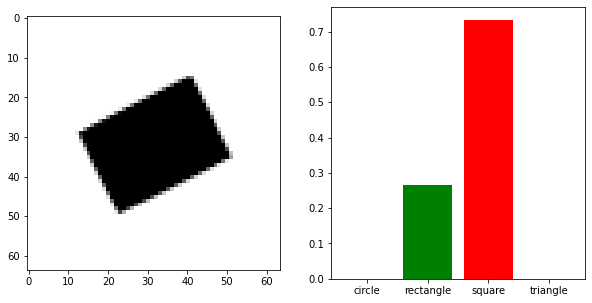

In [48]:
for k in range(10):
    show_main_mistake_k(k, X_val, Y_val_classes, Y_val_pred_class, main_incorrect_preds, prob_preds = main_pred_prob)

Layer number 0 with 5 filters


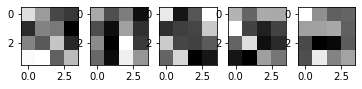

Layer number 1 with 5 filters


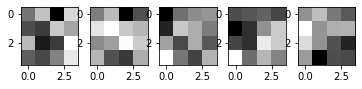

Layer number 2 with 5 filters


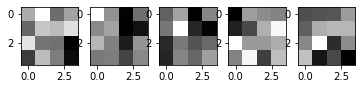

In [49]:
visualize_conv_layers(main_model, main_filters)

# EXPL TASK TRAINING

In [50]:
epochs = 250
lr = 1e-3
lr_decay = lr/epochs
batch_size = 64
optimizer = tfk.optimizers.Nadam(lr, decay=lr_decay)
steps_per_epoch = int(X_train.shape[0]/batch_size)

mirror_setex_hdl.prepare_expl_training()
expl_model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

Main layers disabled for training


In [51]:
expl_model.summary()

Model: "Expl_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer (InputLayer)        [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
Main_Conv_0 (Conv2D)            (None, 61, 61, 5)    85          Input_layer[0][0]                
__________________________________________________________________________________________________
Main_BatchNorm_0 (BatchNormaliz (None, 61, 61, 5)    20          Main_Conv_0[0][0]                
__________________________________________________________________________________________________
Main_MaxPool_0 (MaxPooling2D)   (None, 30, 30, 5)    0           Main_BatchNorm_0[0][0]           
_________________________________________________________________________________________

In [52]:
%%time
mcp_save = tfk.callbacks.ModelCheckpoint('./best_expl_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
expl_hist = expl_model.fit(X_train, Y_expl_train, batch_size=batch_size, validation_data=(X_val, Y_expl_val), steps_per_epoch=steps_per_epoch, epochs=epochs, callbacks=[mcp_save])

Epoch 1/250
93/93 [==============================] - 1s 10ms/step - loss: 0.6644 - accuracy: 0.1144 - val_loss: 0.5828 - val_accuracy: 0.1682
Epoch 2/250
93/93 [==============================] - 1s 9ms/step - loss: 0.5235 - accuracy: 0.2522 - val_loss: 0.5012 - val_accuracy: 0.3573
Epoch 3/250
93/93 [==============================] - 1s 8ms/step - loss: 0.4503 - accuracy: 0.2951 - val_loss: 0.4236 - val_accuracy: 0.3325
Epoch 4/250
93/93 [==============================] - 1s 9ms/step - loss: 0.3742 - accuracy: 0.3565 - val_loss: 0.3516 - val_accuracy: 0.3665
Epoch 5/250
93/93 [==============================] - 1s 9ms/step - loss: 0.3001 - accuracy: 0.4148 - val_loss: 0.2939 - val_accuracy: 0.4267
Epoch 6/250
93/93 [==============================] - 1s 9ms/step - loss: 0.2406 - accuracy: 0.5110 - val_loss: 0.2259 - val_accuracy: 0.5360
Epoch 7/250
93/93 [==============================] - 1s 9ms/step - loss: 0.1883 - accuracy: 0.6237 - val_loss: 0.1776 - val_accuracy: 0.6230
Epoch 8/250


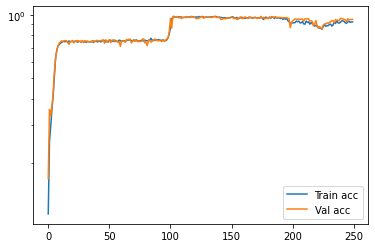

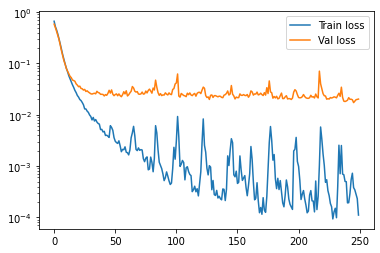

Minimum loss on training: 9.350119944429025e-05 at epoch: 229
Minimum loss on validation: 0.01724734529852867 at epoch: 246
Maximum acc on training: 0.9831536412239075 at epoch: 138
Maximum acc on validation: 0.984333336353302 at epoch: 103
188/188 [==============================] - 0s 2ms/step - loss: 0.0232 - accuracy: 0.9843
Val score of best saved model: 0.984333336353302
188/188 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 0.9902
Train score of best saved model: 0.9901666641235352


In [53]:
plt.plot(expl_hist.history['accuracy'], label='Train acc')
plt.plot(expl_hist.history['val_accuracy'], label='Val acc')
plt.legend()
plt.yscale('log')
plt.show()

plt.plot(expl_hist.history['loss'], label='Train loss')
plt.plot(expl_hist.history['val_loss'], label='Val loss')
plt.legend()
plt.yscale('log')
plt.show()

print('Minimum loss on training:', np.min(expl_hist.history['loss']),'at epoch:', np.argmin(expl_hist.history['loss'])+1)
print('Minimum loss on validation:', np.min(expl_hist.history['val_loss']),'at epoch:', np.argmin(expl_hist.history['val_loss'])+1)
print('Maximum acc on training:', np.max(expl_hist.history['accuracy']),'at epoch:', np.argmax(expl_hist.history['accuracy'])+1)
print('Maximum acc on validation:', np.max(expl_hist.history['val_accuracy']),'at epoch:', np.argmax(expl_hist.history['val_accuracy'])+1)

expl_model = tfk.models.load_model('./best_expl_model.h5')
best_val_acc = expl_model.evaluate(X_val, Y_expl_val)[1]
print('Val score of best saved model:', best_val_acc)

best_train_acc = expl_model.evaluate(X_train, Y_expl_train)[1]
print('Train score of best saved model:', best_train_acc)

# SETEX EVALUATION

In [0]:
# losses = {'Main_Model':'categorical_crossentropy', 'Expl_Model':'binary_crossentropy'}
# loss_weights = {'Main_Model':1.0, 'Expl_Model':1.0}
# setex_model.compile(optimizer, loss=losses, loss_weights=loss_weights)

# # mirror_setex_hdl.prepare_setex_training()
# setex_model.evaluate(X_val, {'Main_Model':Y_val, 'Expl_Model':Y_expl_val})

In [55]:
################### CONSISTENCY VALIDATIONS AFTER TWO STEP TRAINING ##################

main_model = mirror_setex_hdl.main_model
main_pred_prob = main_model.predict(X_val)
Y_val_classes, Y_val_pred_class = Y_val.argmax(axis=1), main_pred_prob.argmax(axis=1)
main_incorrect_preds = np.where(Y_val_classes != Y_val_pred_class)[0]

strict_matrix = confusion_matrix(Y_val_classes, Y_val_pred_class).T
print('Confusion matrix of Main_Model through Main_Model')
print(lb.classes_)
print(strict_matrix)
print('A total of',len(main_incorrect_preds),'mistakes found out of',X_val.shape[0])
strict_main_acc = main_model.evaluate(X_val, Y_val)[1]
print(strict_main_acc)

print('\n----------------------------------------------------------------------------------\n')

setex_main_preds, setex_expl_preds = setex_model.predict(X_val)

Y_val_classes, Y_val_pred_class = Y_val.argmax(axis=1), setex_main_preds.argmax(axis=1)
main_incorrect_preds = np.where(Y_val_classes != Y_val_pred_class)[0]

setex_matrix = confusion_matrix(Y_val_classes, Y_val_pred_class).T
print('Confussion matrix of Main_Model through Setex_Model')
print(lb.classes_)
print(setex_matrix)
print('A total of',len(main_incorrect_preds),'mistakes found out of',X_val.shape[0])
setex_main_acc = accuracy_score(Y_val_classes, Y_val_pred_class)
print(setex_main_acc)

print('#####################')

print('Same accuracies?', np.allclose(setex_main_acc, strict_main_acc))
print('Same confusion matrices?', np.sum(abs(setex_matrix-strict_matrix))==0 )

Confusion matrix of Main_Model through Main_Model
['circle' 'rectangle' 'square' 'triangle']
[[1500    1    0    0]
 [   0 1456    1   16]
 [   0   39 1499    0]
 [   0    4    0 1484]]
A total of 61 mistakes found out of 6000
188/188 [==============================] - 0s 2ms/step - loss: 0.0572 - accuracy: 0.9898
0.9898333549499512

----------------------------------------------------------------------------------

Confussion matrix of Main_Model through Setex_Model
['circle' 'rectangle' 'square' 'triangle']
[[1500    1    0    0]
 [   0 1456    1   16]
 [   0   39 1499    0]
 [   0    4    0 1484]]
A total of 61 mistakes found out of 6000
0.9898333333333333
#####################
Same accuracies? True
Same confusion matrices? True


In [0]:
def predict_by_expl(expls):
    # FOLLOWING LABELBINARIZER ORDER
    # ['circle', 'rectangle', 'square', 'triangle']
    # ['EX0', 'EX1', 'EX2', 'EX3', 'EX4']
    num_expls_proposed = np.sum(expls)
    circle_prob = np.sum(np.multiply(expls, [1,0,0,0,0]))/1
    rectangle_prob = np.sum(np.multiply(expls, [0,0,1,1,0]))/2
    square_prob = np.sum(np.multiply(expls, [0,0,1,1,1]))/3
    triangle_prob = np.sum(np.multiply(expls, [0,1,0,0,1]))/2
    predictions_by_expl = np.array( [circle_prob, rectangle_prob, square_prob, triangle_prob] )
    return predictions_by_expl#/np.sum(predictions_by_expl)

    # num_expls_proposed = np.sum(expls)
    # circle_prob = np.sum(np.multiply(expls, [1,-1,-1,-1,-1]))/5
    # rectangle_prob = np.sum(np.multiply(expls, [-1,-1,1,1,-1]))/5
    # square_prob = np.sum(np.multiply(expls, [-1,-1,1,1,1]))/5
    # triangle_prob = np.sum(np.multiply(expls, [-1,1,-1,-1,1]))/5
    # predictions_by_expl = np.array( [circle_prob, rectangle_prob, square_prob, triangle_prob] )
    # return predictions_by_expl#/np.sum(predictions_by_expl)

def show_setex_mistake_k(k, X, Y_classes, Y_pred_classes, Y_expl, Y_pred_expl, incorrect_preds, prob_preds=None):
    # incorrect_preds = np.where(Y_classes != Y_pred_classes)[0]
    # print(incorrect_preds)
    # print(Y_classes[incorrect_preds])
    # print(Y_pred_classes[incorrect_preds])

    # print('A total of',len(incorrect_preds),'mistakes found')

    index = incorrect_preds[min(k, incorrect_preds.shape[0]-1)]
    mistake_img, true_label, pred_label = X[index], Y_classes[index], Y_pred_classes[index]
    true_expl, pred_expl = Y_expl[index], Y_pred_expl[index]

    print('True class:', lb.classes_[true_label])
    print('True explanations:', true_expl)
    predictions_by_true_expl = predict_by_expl(true_expl)
    print('Prediction by true explanations:', predictions_by_true_expl)
    print('#######')
    print('Predicted class:', lb.classes_[pred_label])
    print('Predicted explanations:', pred_expl)
    predictions_by_expl = predict_by_expl(pred_expl)
    print('Prediction by predicted explanations:', predictions_by_expl)

    if prob_preds is not None:
        mistake_probs = prob_preds[index]

        # print('Max probability:', np.max(mistake_probs))
        fig, axis = plt.subplots(1, 3, figsize=(15, 5))
        if mistake_img.shape[-1]==1:
            axis[0].imshow(np.squeeze(mistake_img), cmap='gray')
        else: axis[0].imshow(mistake_img)
        axis[1].bar(x=lb.classes_, height=mistake_probs, color=['r' if i != true_label else 'g' for i in range(len(lb.classes_))])
        axis[2].bar(x=lb.classes_, height=predictions_by_expl, color=['r' if i != true_label else 'g' for i in range(len(lb.classes_))])

        axis[0].set_title('Input Sample')
        axis[1].set_title('Main probabilities')
        axis[2].set_title('Confidences by explanations')
        plt.show()
    else:
        fig, axis = plt.subplots(1, 2, figsize=(10, 5))
        if mistake_img.shape[-1]==1: axis[0].imshow(np.squeeze(mistake_img), cmap='gray')
        else: axis[0].imshow(mistake_img)
        axis[1].bar(x=lb.classes_, height=predictions_by_expl, color=['r' if i != true_label else 'g' for i in range(len(lb.classes_))])

        axis[0].set_title('Input Sample')
        axis[1].set_title('Confidences by explanations')
        plt.show()

    print('--------------------')


def show_setex_correct_k(k, X, Y_classes, Y_pred_classes, Y_expl, Y_pred_expl, correct_preds, prob_preds=None):
    # incorrect_preds = np.where(Y_classes != Y_pred_classes)[0]
    # print(incorrect_preds)
    # print(Y_classes[incorrect_preds])
    # print(Y_pred_classes[incorrect_preds])

    # print('A total of',len(incorrect_preds),'mistakes found')

    index = correct_preds[min(k, correct_preds.shape[0]-1)]
    mistake_img, true_label, pred_label = X[index], Y_classes[index], Y_pred_classes[index]
    true_expl, pred_expl = Y_expl[index], Y_pred_expl[index]

    print('True class:', lb.classes_[true_label])
    print('True explanations:', true_expl)
    predictions_by_true_expl = predict_by_expl(true_expl)
    print('Prediction by true explanations:', predictions_by_true_expl)
    print('#######')
    print('Predicted class:', lb.classes_[pred_label])
    print('Predicted explanations:', pred_expl)
    predictions_by_expl = predict_by_expl(pred_expl)
    print('Prediction by predicted explanations:', predictions_by_expl)

    if prob_preds is not None:
        mistake_probs = prob_preds[index]

        # print('Max probability:', np.max(mistake_probs))
        fig, axis = plt.subplots(1, 3, figsize=(15, 5))
        if mistake_img.shape[-1]==1:
            axis[0].imshow(np.squeeze(mistake_img), cmap='gray')
        else: axis[0].imshow(mistake_img)
        axis[1].bar(x=lb.classes_, height=mistake_probs, color=['r' if i != true_label else 'g' for i in range(len(lb.classes_))])
        axis[2].bar(x=lb.classes_, height=predictions_by_expl, color=['r' if i != true_label else 'g' for i in range(len(lb.classes_))])

        axis[0].set_title('Input Sample')
        axis[1].set_title('Main probabilities')
        axis[2].set_title('Confidences by explanations')
        plt.show()
    else:
        fig, axis = plt.subplots(1, 2, figsize=(10, 5))
        if mistake_img.shape[-1]==1: axis[0].imshow(np.squeeze(mistake_img), cmap='gray')
        else: axis[0].imshow(mistake_img)
        axis[1].bar(x=lb.classes_, height=predictions_by_expl, color=['r' if i != true_label else 'g' for i in range(len(lb.classes_))])

        axis[0].set_title('Input Sample')
        axis[1].set_title('Confidences by explanations')
        plt.show()

    print('--------------------')

def is_setex_correct_k(k, X, Y_classes, Y_pred_classes, Y_expl, Y_pred_expl, correct_preds, prob_preds):
    # incorrect_preds = np.where(Y_classes != Y_pred_classes)[0]
    # print(incorrect_preds)
    # print(Y_classes[incorrect_preds])
    # print(Y_pred_classes[incorrect_preds])

    # print('A total of',len(incorrect_preds),'mistakes found')

    index = correct_preds[min(k, correct_preds.shape[0]-1)]
    mistake_img, true_label, pred_label = X[index], Y_classes[index], Y_pred_classes[index]
    true_expl, pred_expl = Y_expl[index], Y_pred_expl[index]

    predictions_by_expl = predict_by_expl(pred_expl)
    prediction_by_expl = np.argwhere(predictions_by_expl == np.max(predictions_by_expl)).flatten()


    main_probs = prob_preds[index]
    main_prediction = np.argmax(main_probs)

    # print(predictions_by_expl, main_probs)
    # print(prediction_by_expl, main_prediction)

    return main_prediction in prediction_by_expl


In [0]:
expl_threshold = 0.5
setex_main_preds, setex_expl_preds = setex_model.predict(X_val)
setex_expl_preds = (setex_expl_preds >= expl_threshold)*1

Y_val_classes, Y_val_pred_class = Y_val.argmax(axis=1), setex_main_preds.argmax(axis=1)
main_incorrect_preds = np.where(Y_val_classes != Y_val_pred_class)[0]
main_correct_preds = np.where(Y_val_classes == Y_val_pred_class)[0]

True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


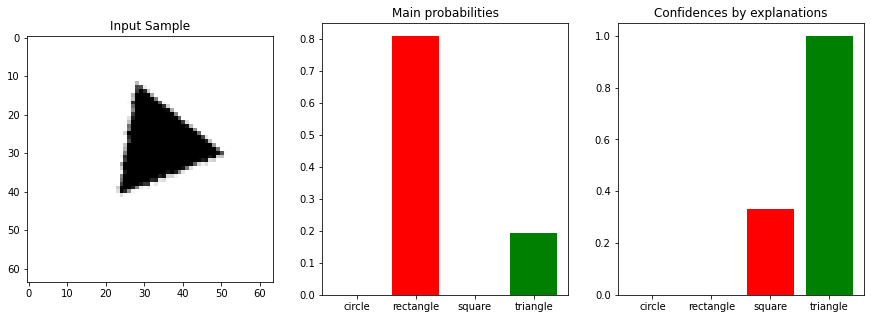

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


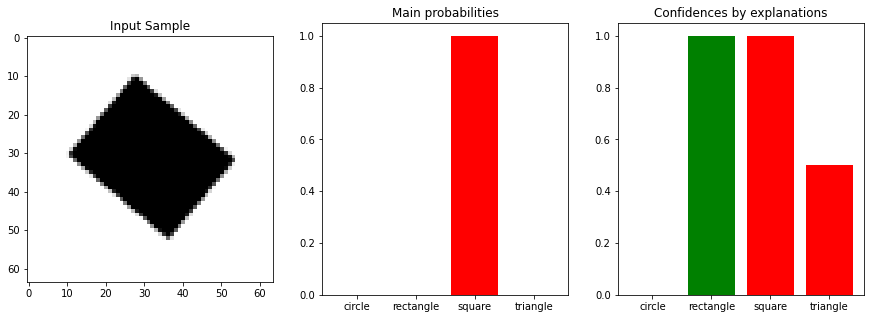

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


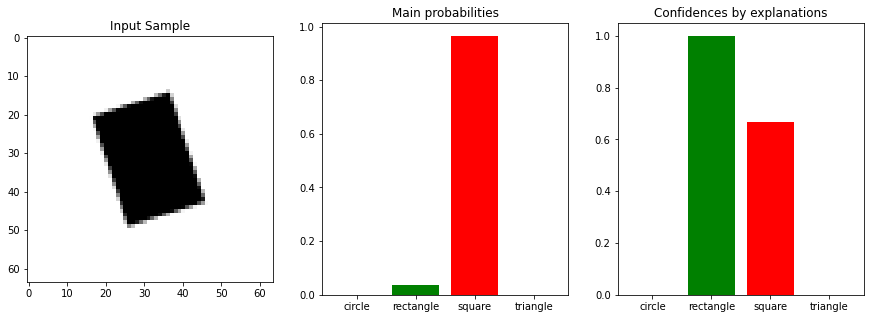

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


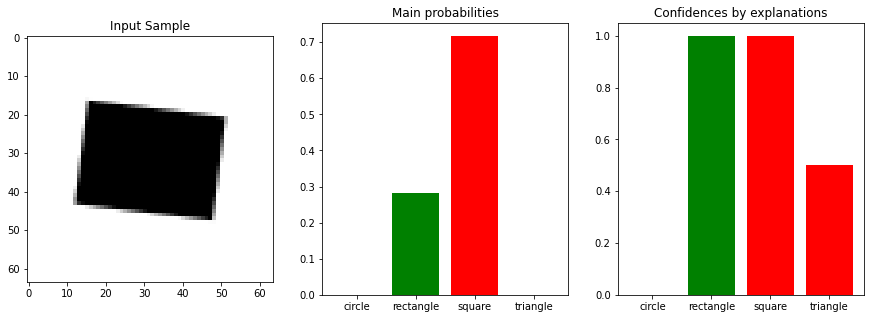

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


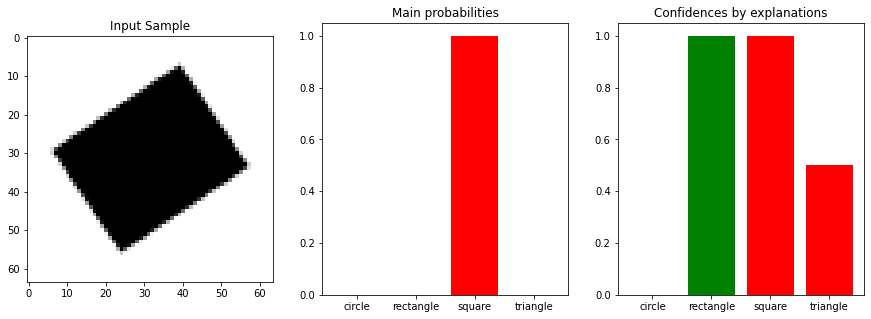

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


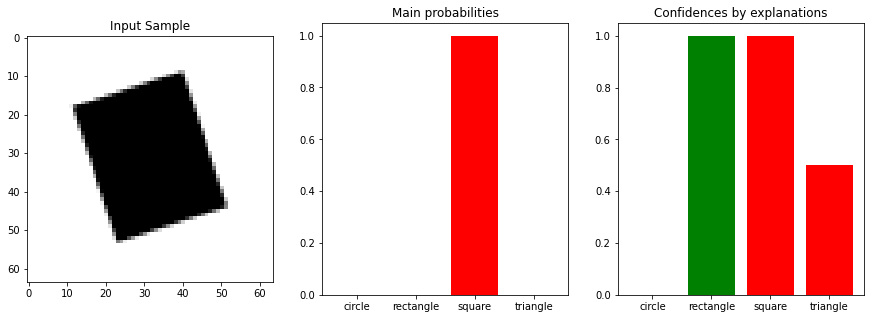

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


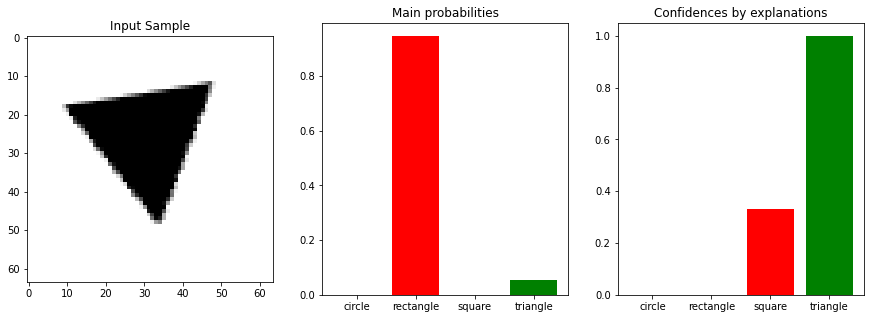

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


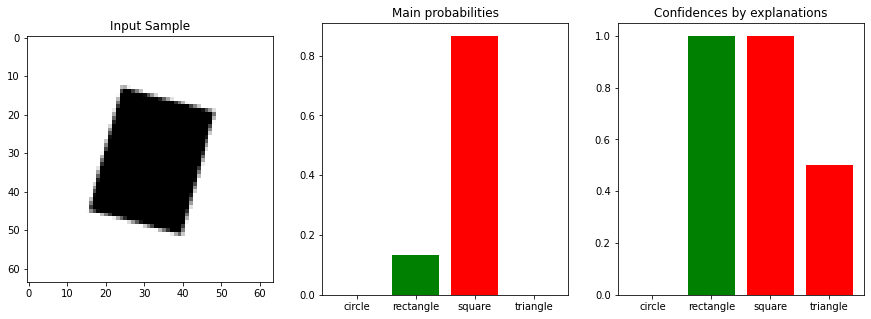

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


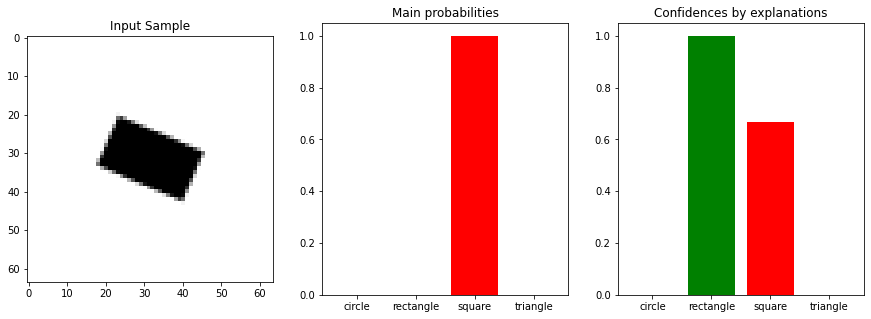

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


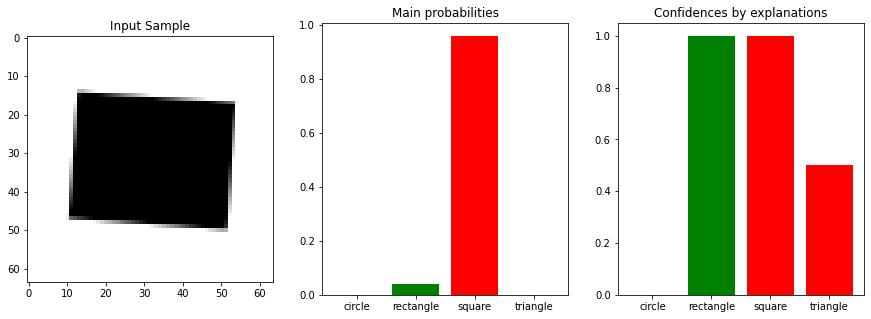

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


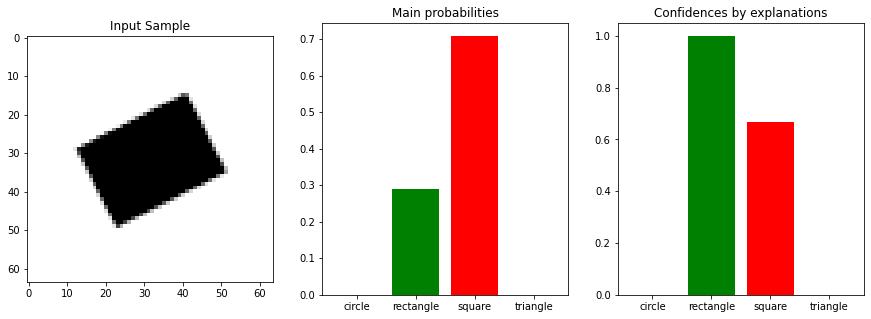

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


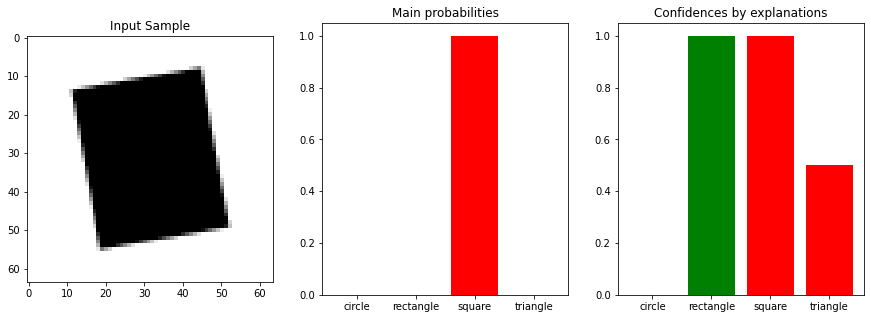

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


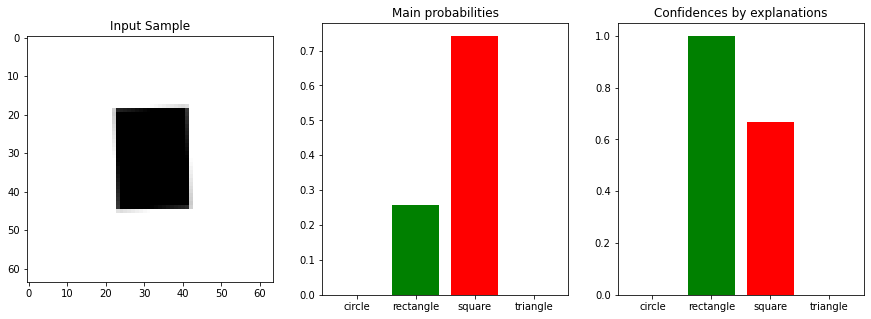

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


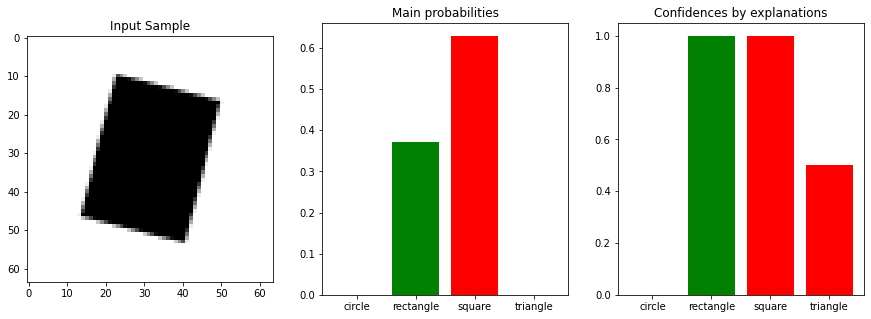

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


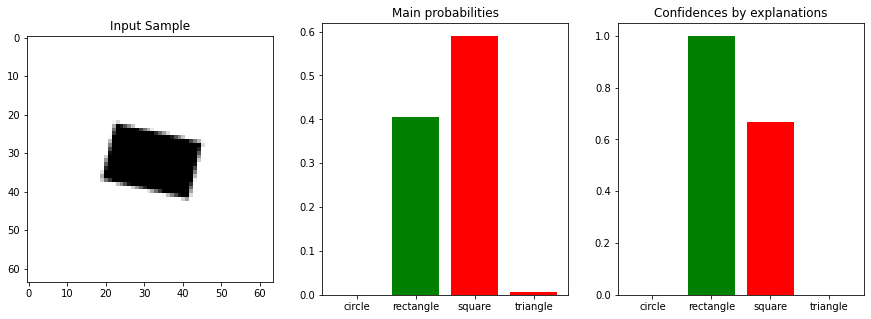

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


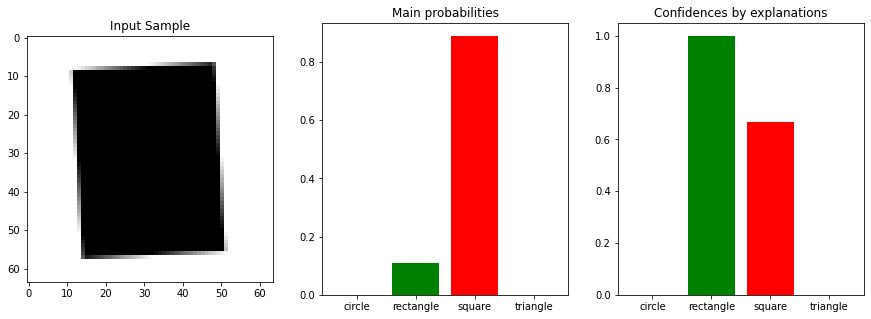

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


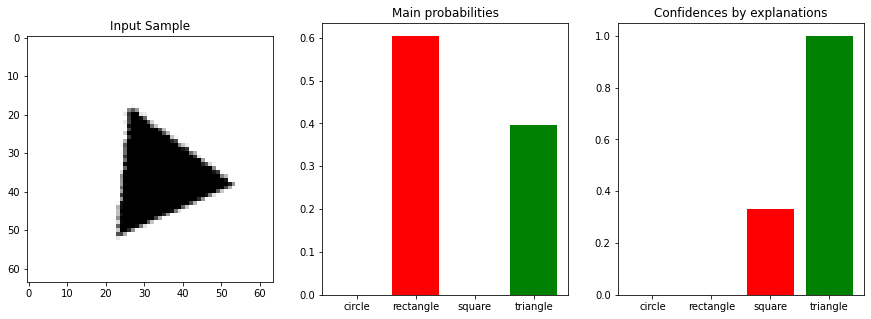

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


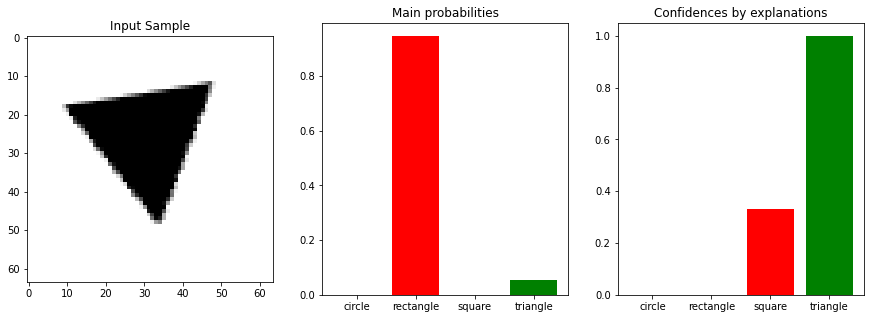

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


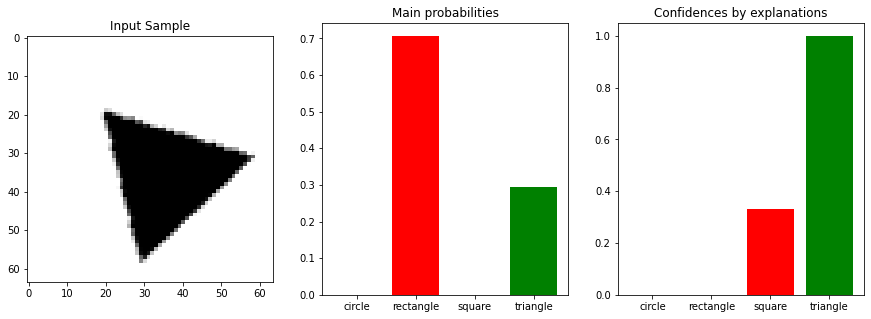

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


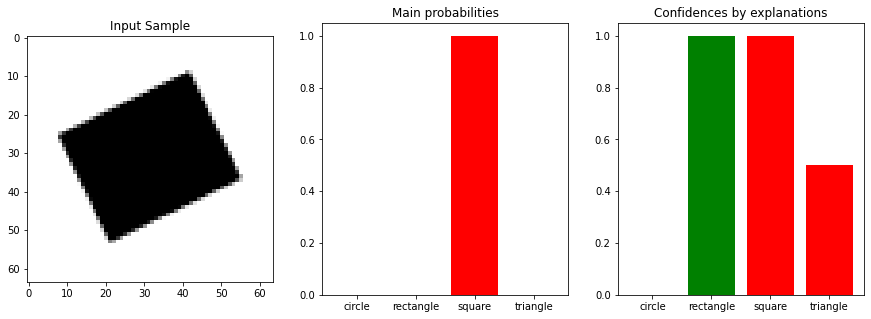

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: triangle
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


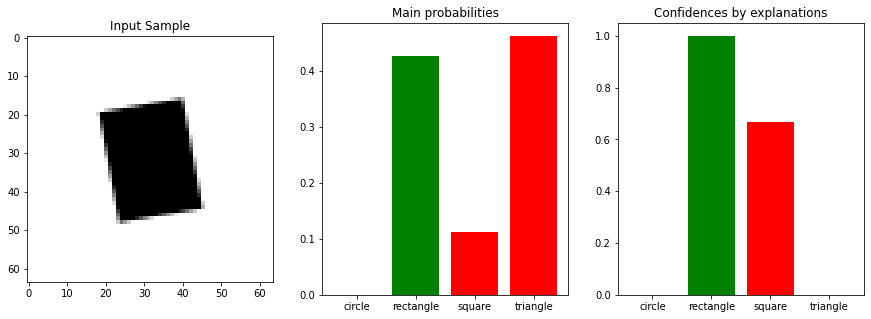

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


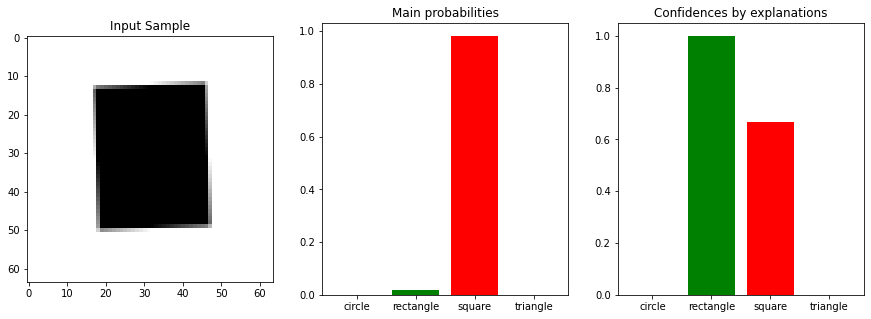

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


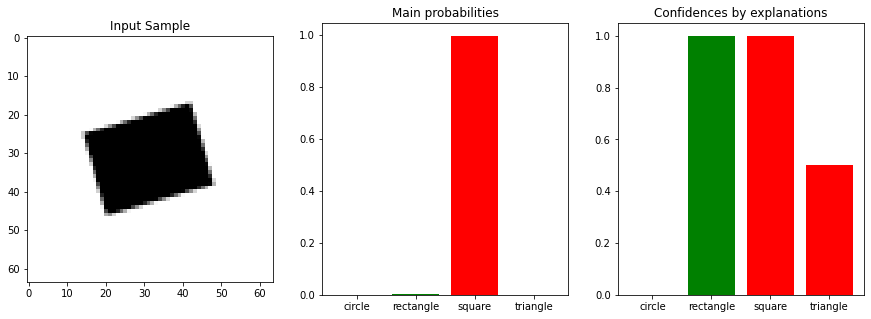

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


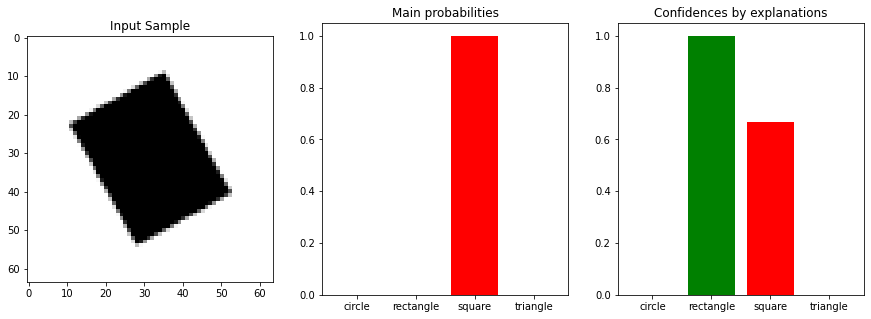

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


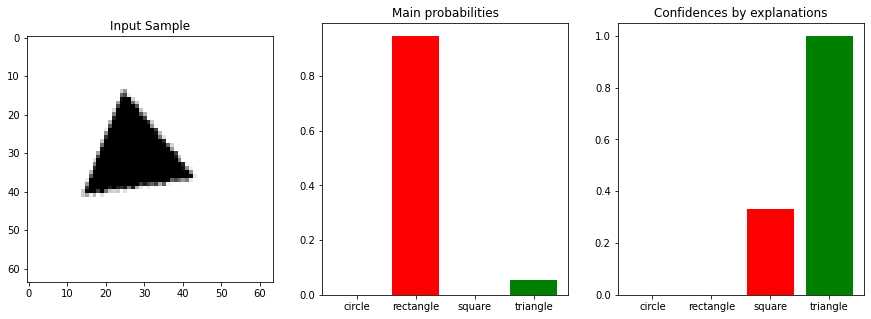

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


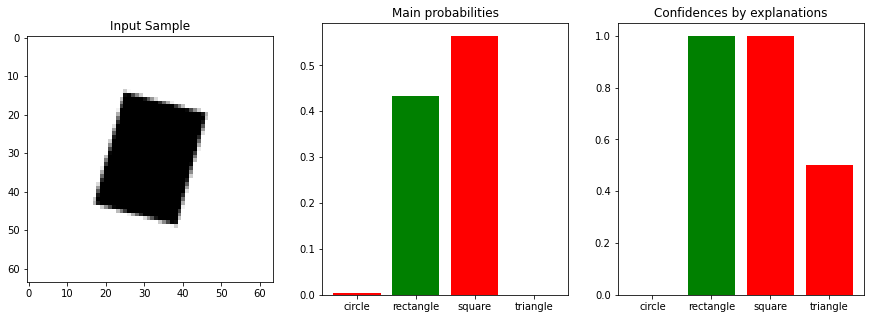

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


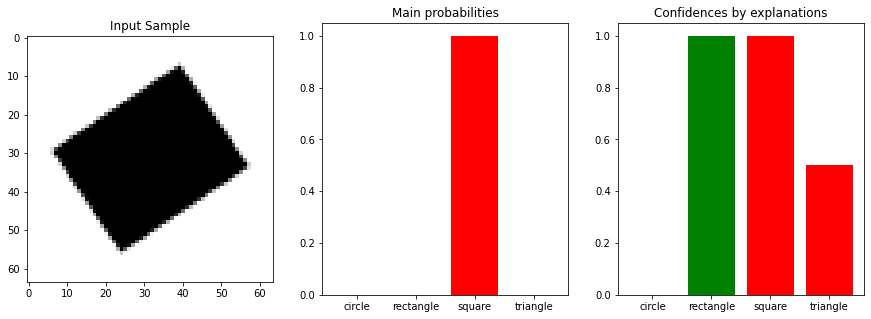

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


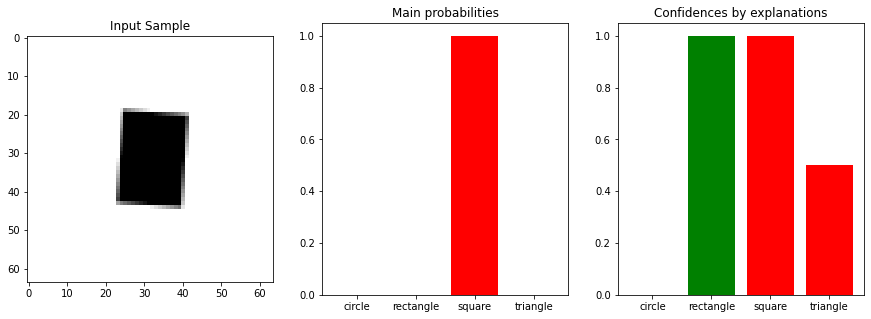

--------------------
True class: square
True explanations: [0 0 1 1 1]
Prediction by true explanations: [0.  1.  1.  0.5]
#######
Predicted class: rectangle
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


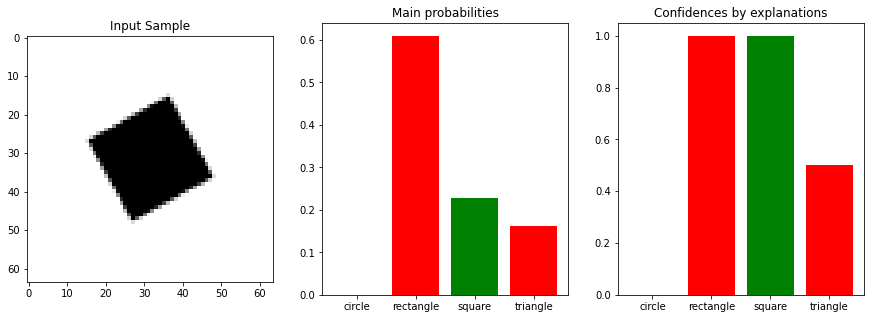

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: triangle
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


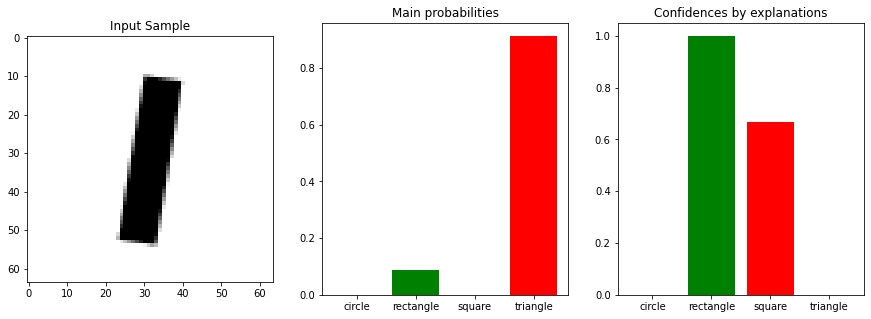

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


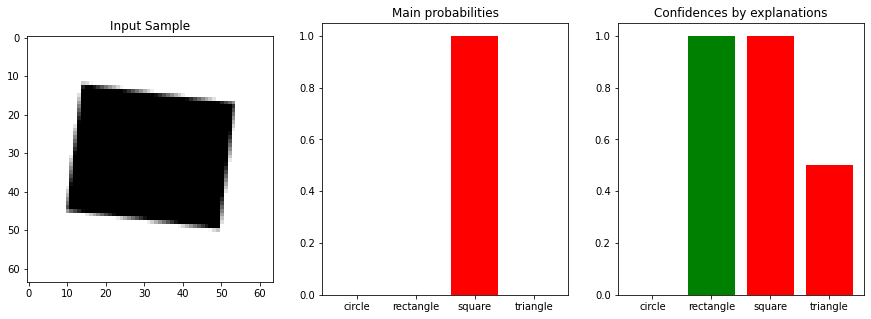

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


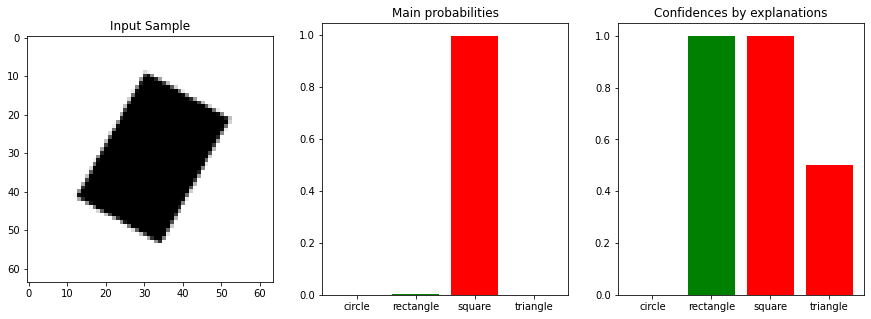

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: triangle
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


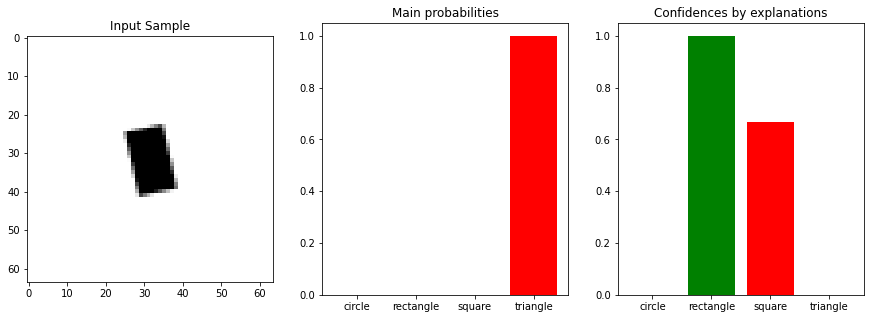

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


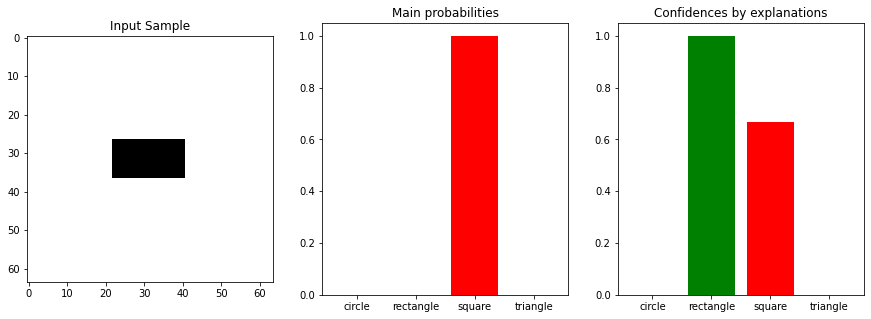

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


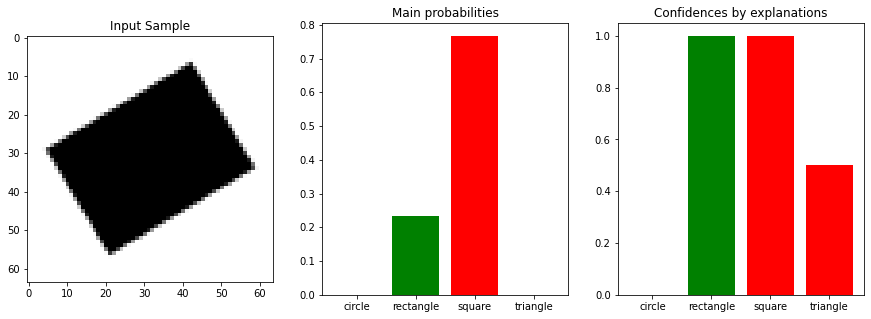

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


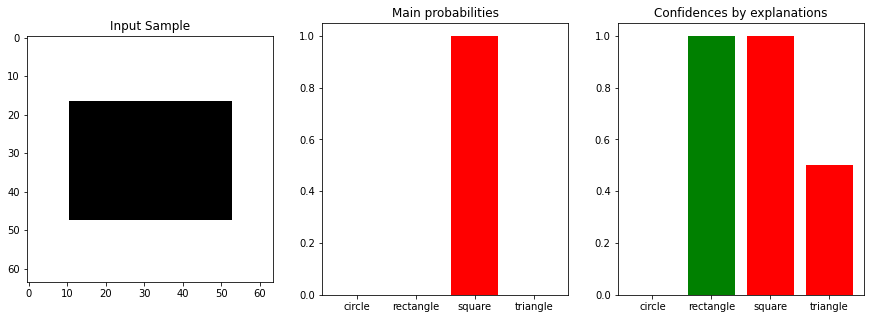

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: triangle
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


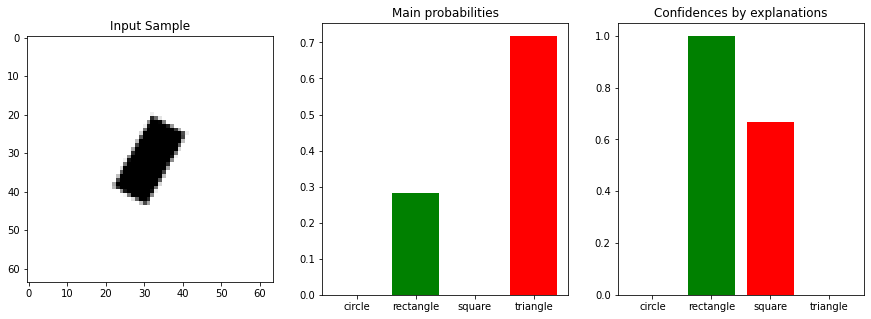

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


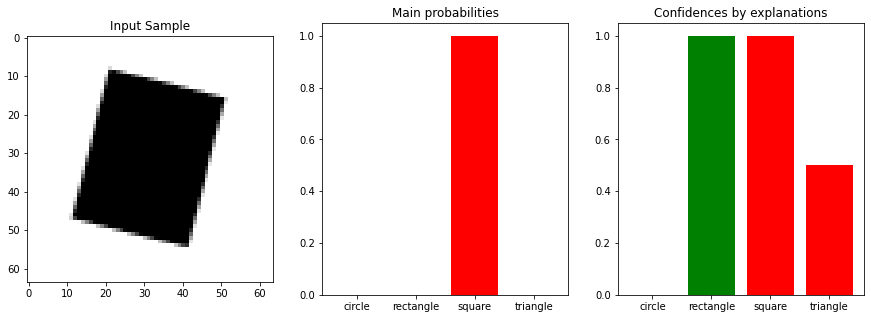

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


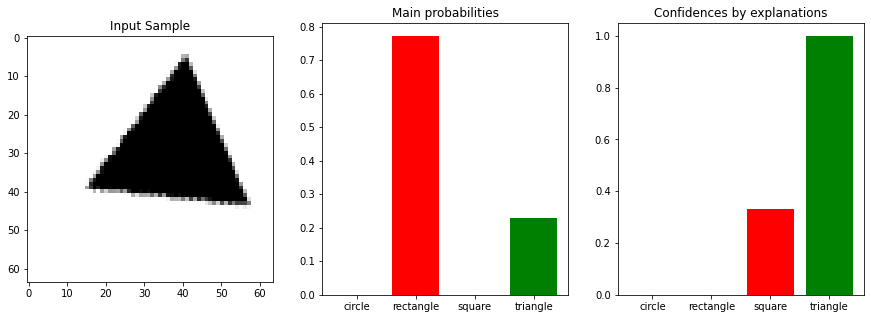

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


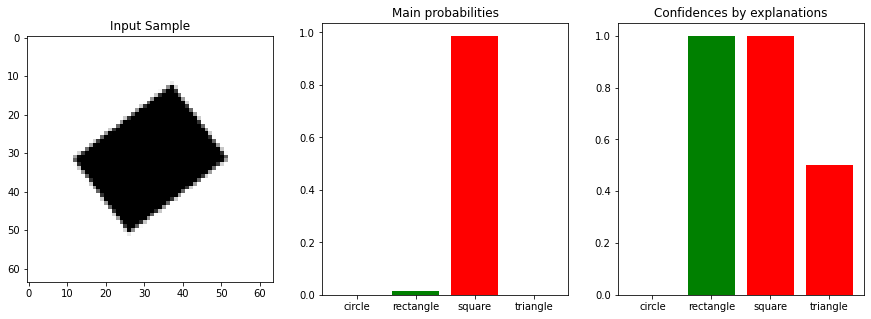

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


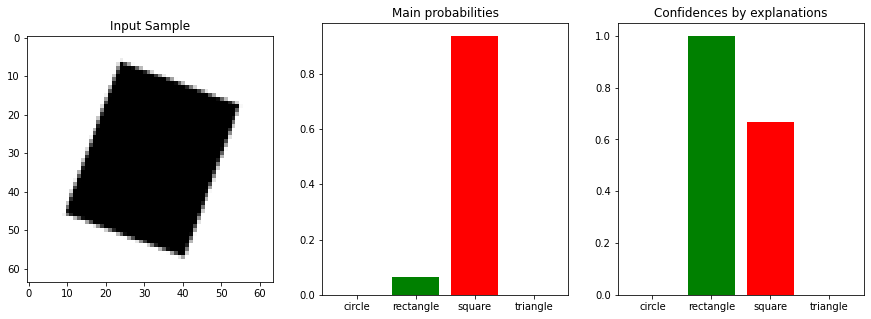

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


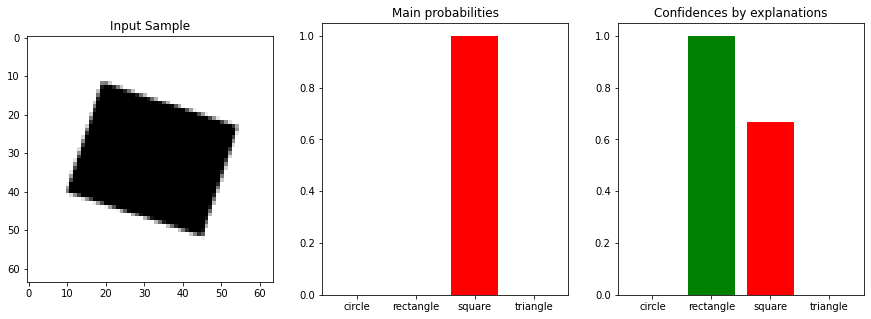

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


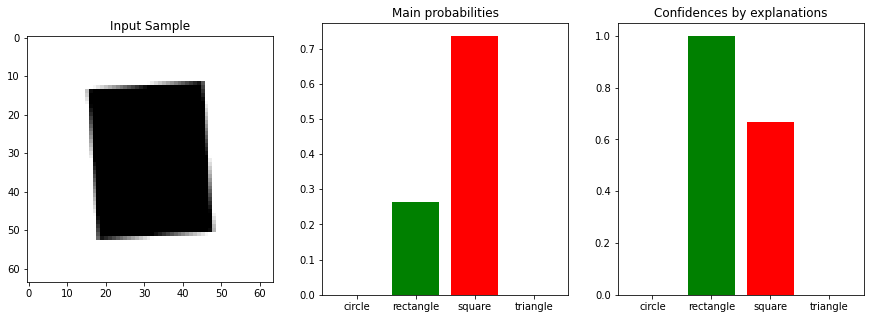

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


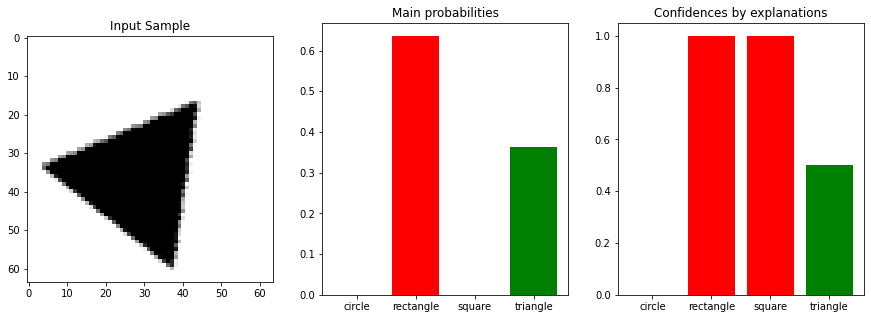

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


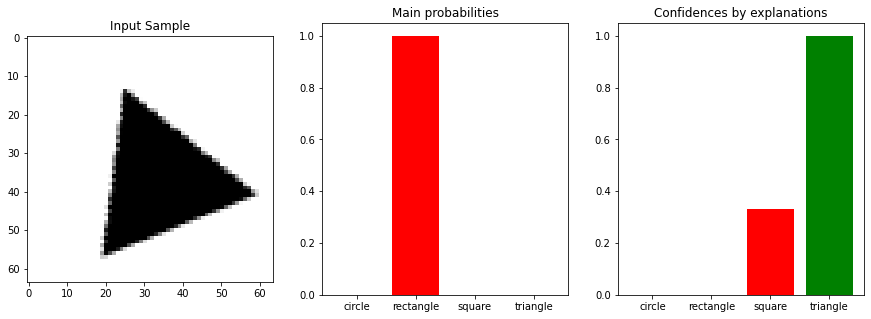

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


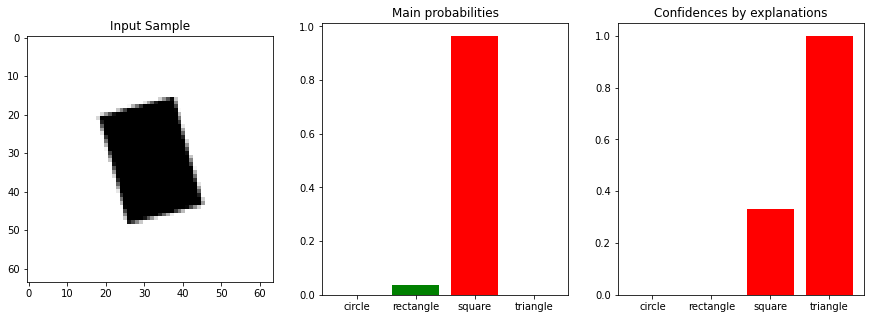

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


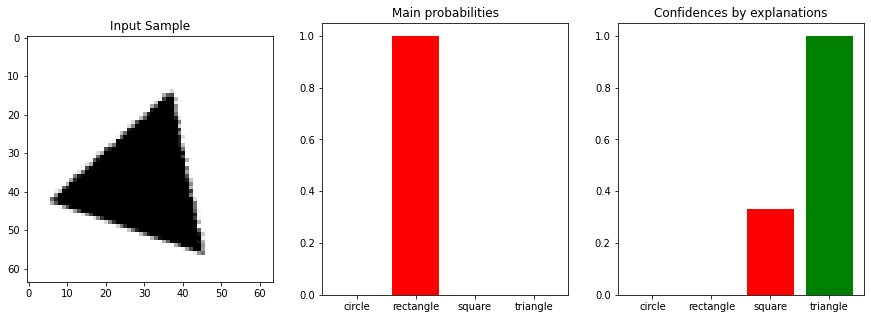

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


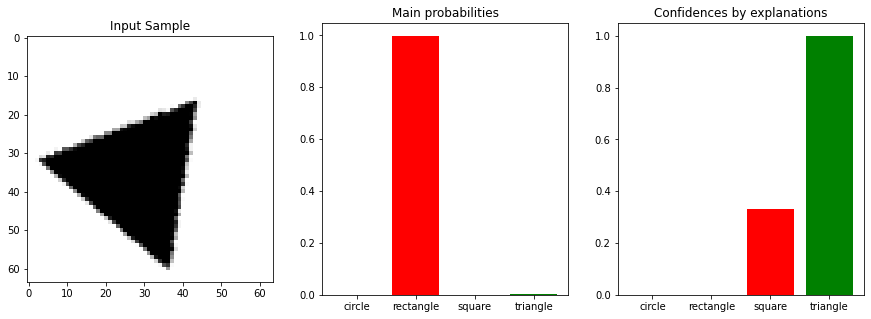

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


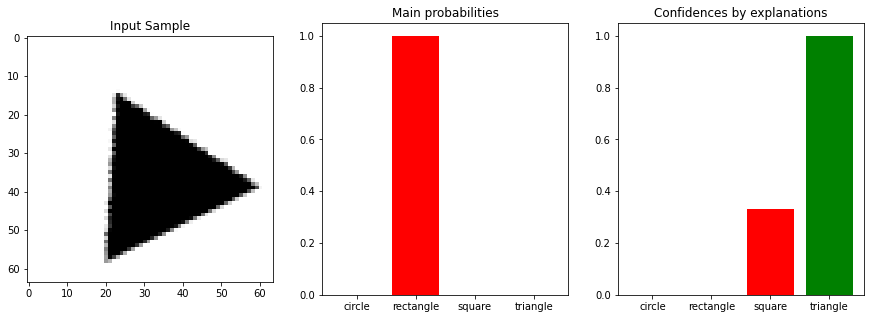

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


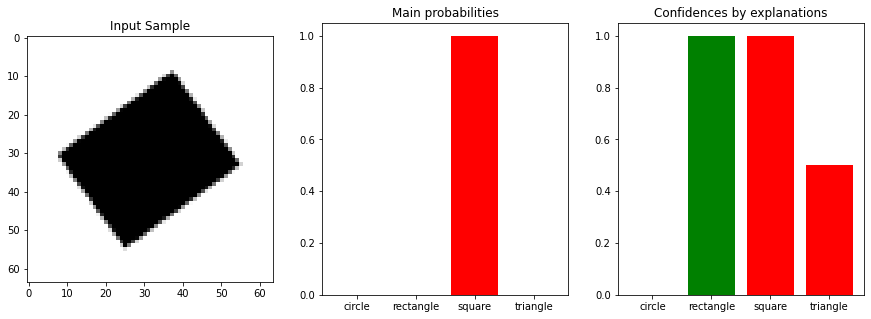

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


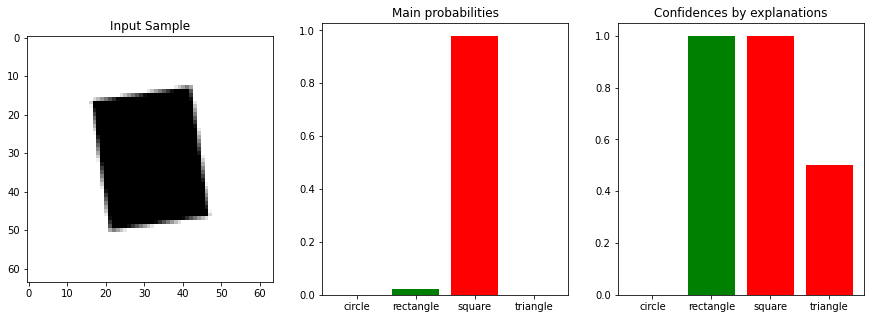

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


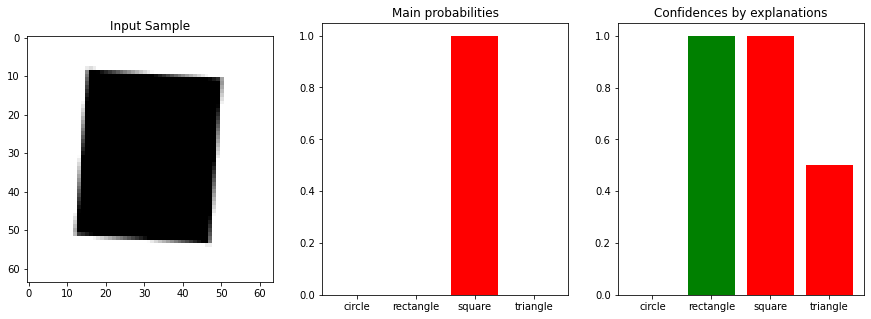

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


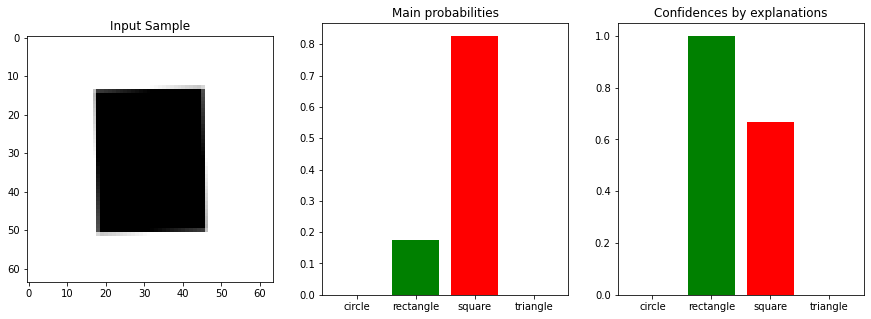

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


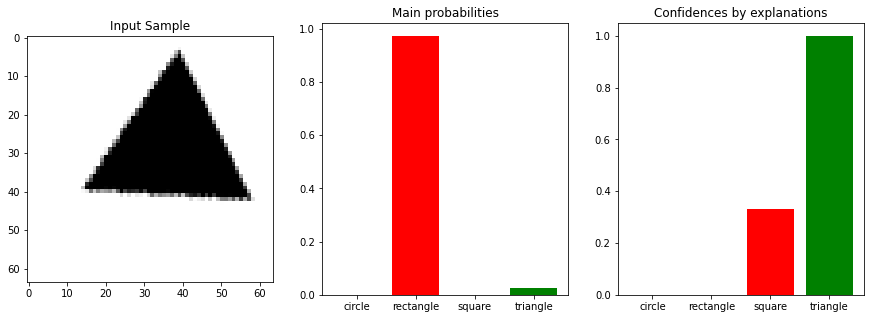

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


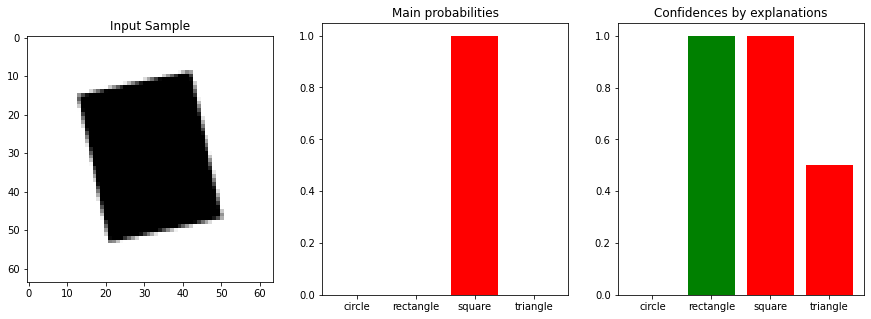

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


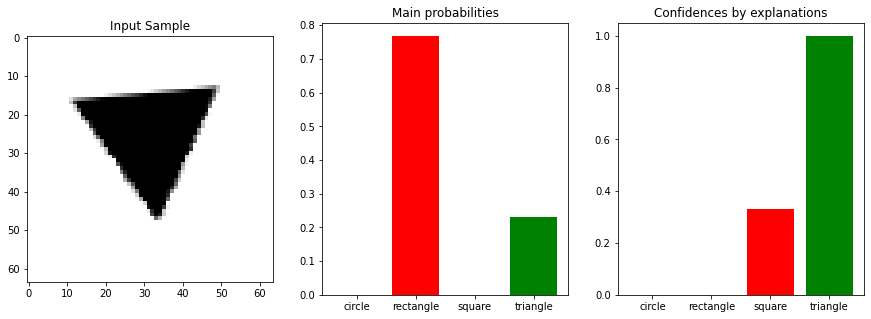

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


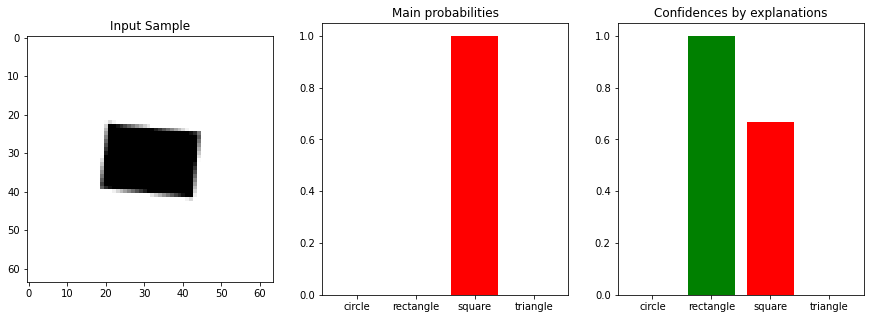

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


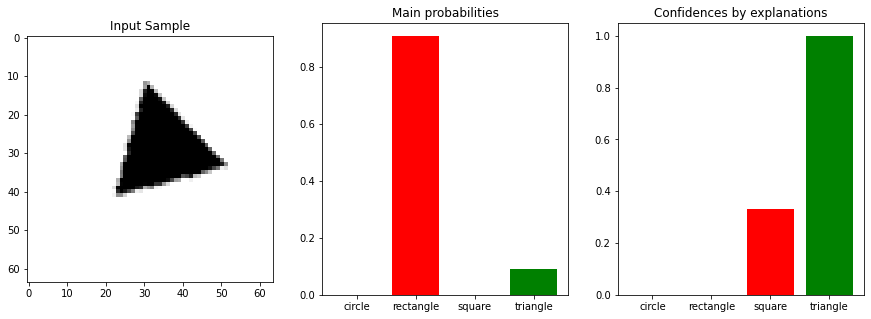

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


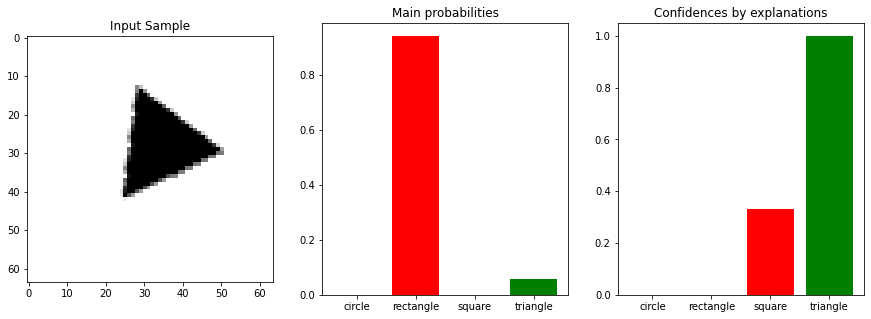

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: circle
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


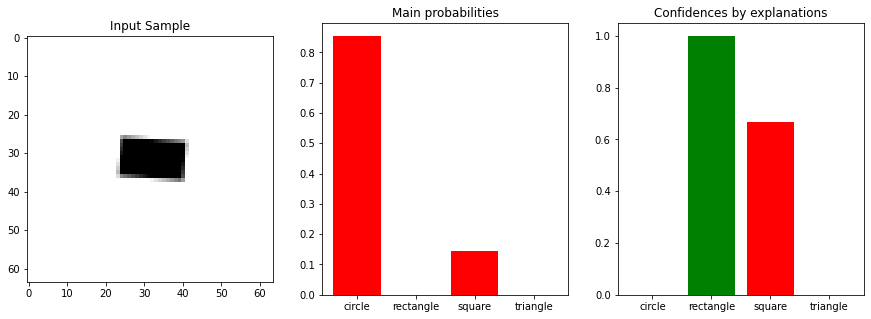

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


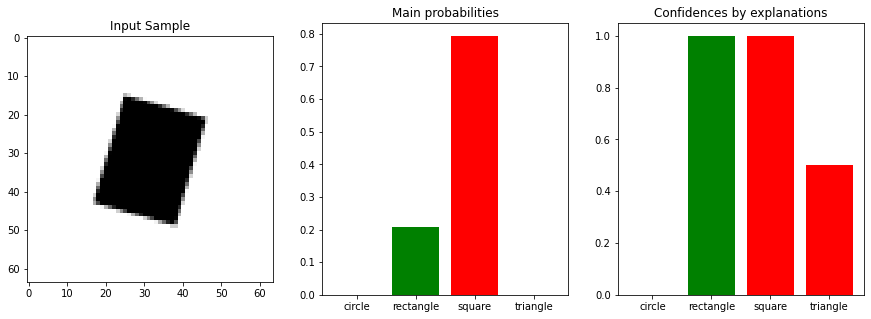

--------------------


In [68]:
for k in range(61):
    show_setex_mistake_k(k, X_val, Y_val_classes, Y_val_pred_class, Y_expl_val, setex_expl_preds, main_incorrect_preds, prob_preds=setex_main_preds)

In [97]:
correct_cross_comparisons = 0
for k in range(main_incorrect_preds.shape[0]):
    correct_cross_comparisons += is_setex_correct_k(k, X_val, Y_val_classes, Y_val_pred_class, Y_expl_val, setex_expl_preds, main_incorrect_preds, prob_preds=setex_main_preds)

print(main_incorrect_preds.shape[0])
print(correct_cross_comparisons/main_incorrect_preds.shape[0])
print(1-correct_cross_comparisons/main_incorrect_preds.shape[0])

61
0.4262295081967213
0.5737704918032787


True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


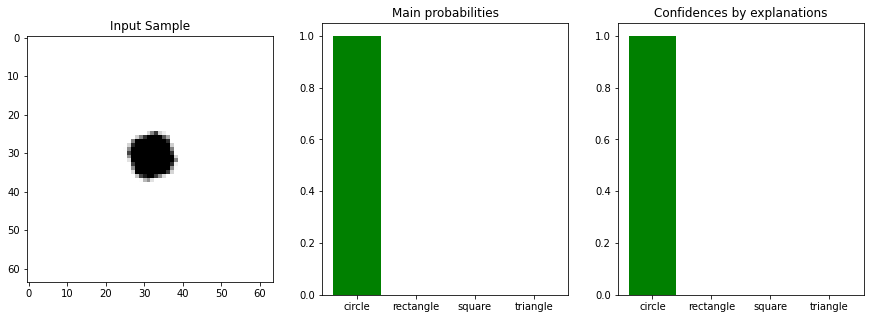

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


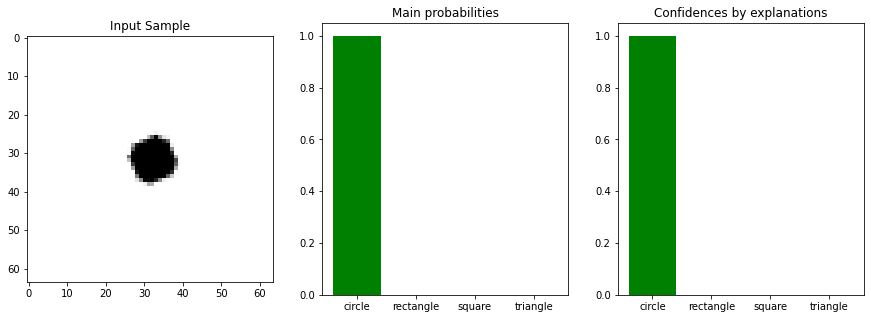

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


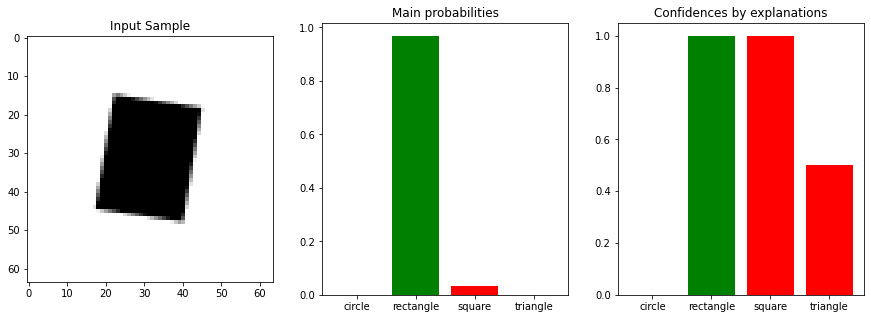

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


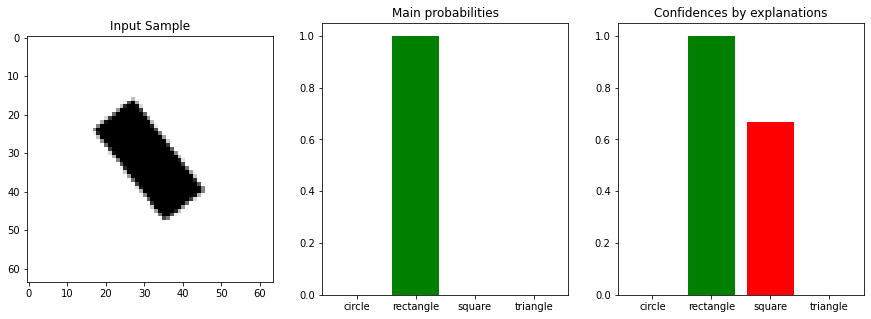

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: triangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


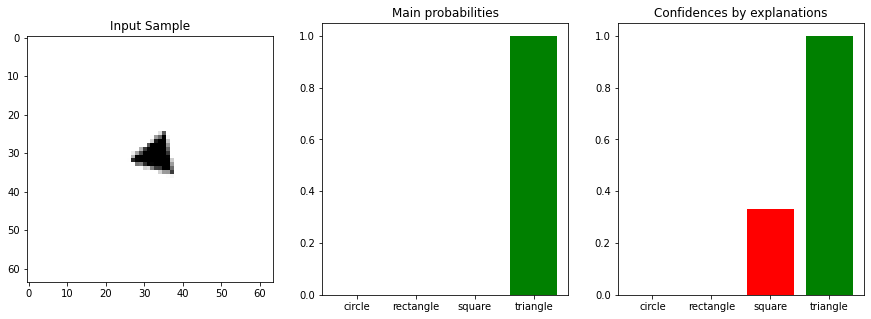

--------------------
True class: square
True explanations: [0 0 1 1 1]
Prediction by true explanations: [0.  1.  1.  0.5]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


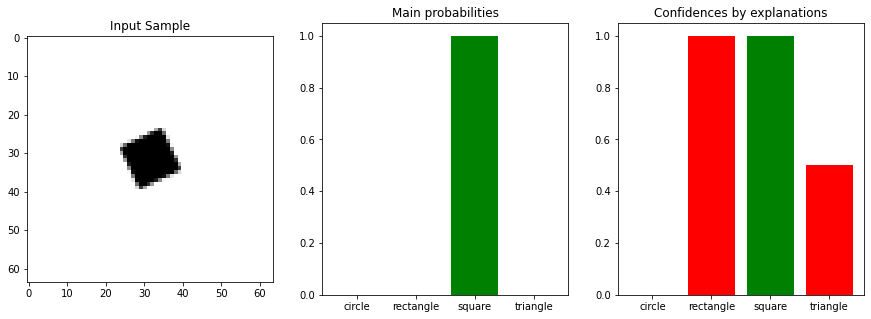

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


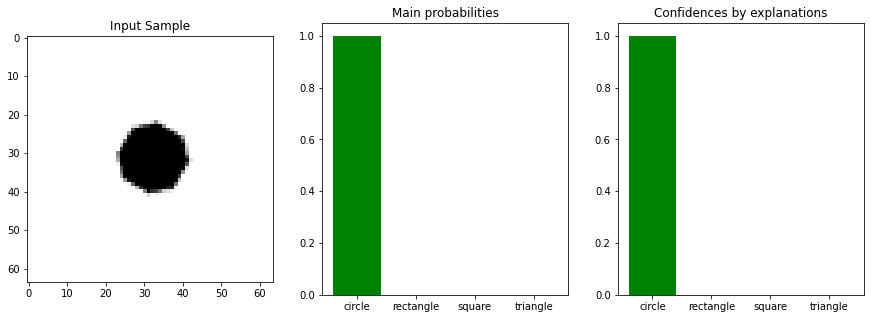

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: triangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


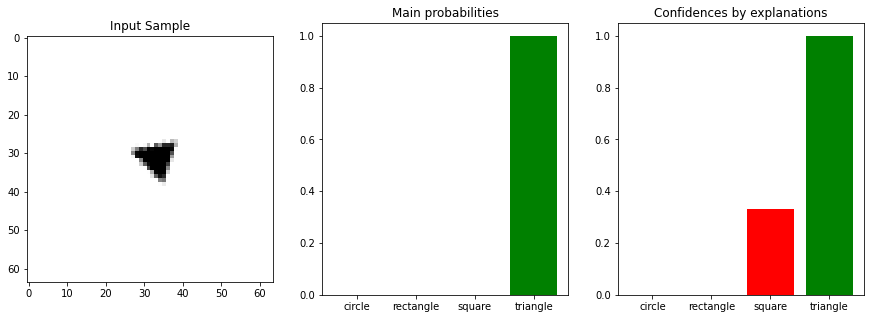

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: rectangle
Predicted explanations: [1 0 1 1 0]
Prediction by predicted explanations: [1.         1.         0.66666667 0.        ]


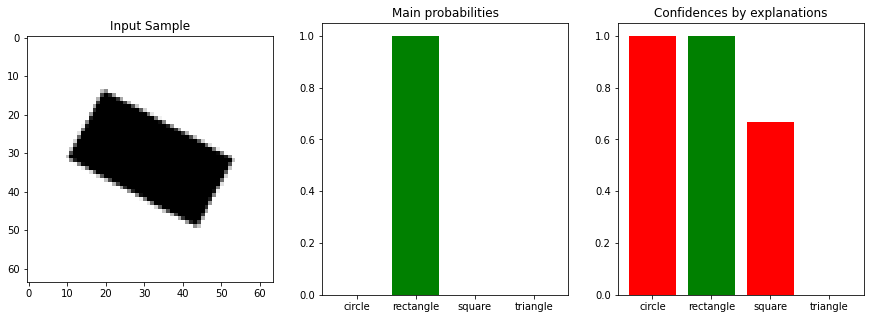

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


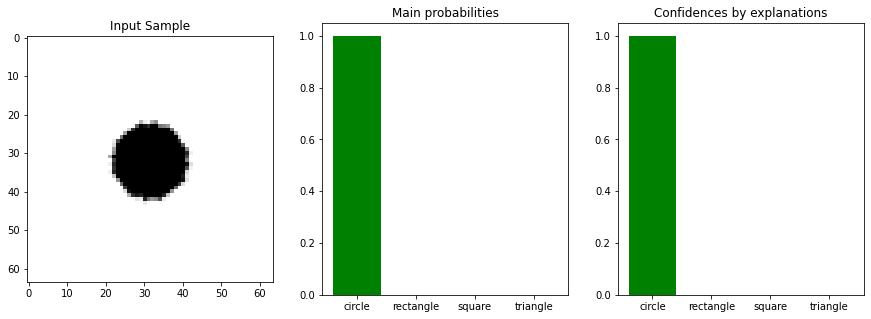

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: triangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


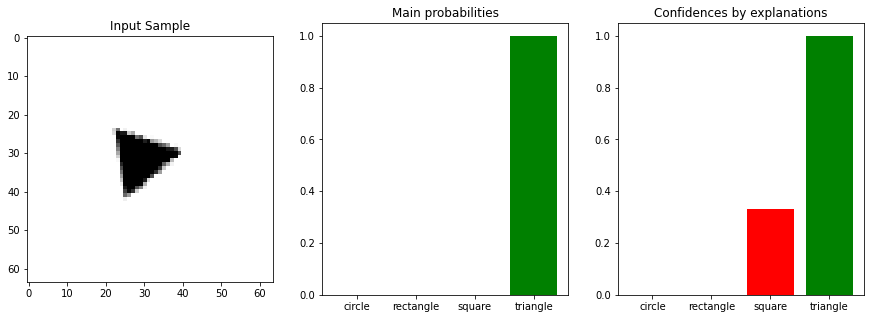

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


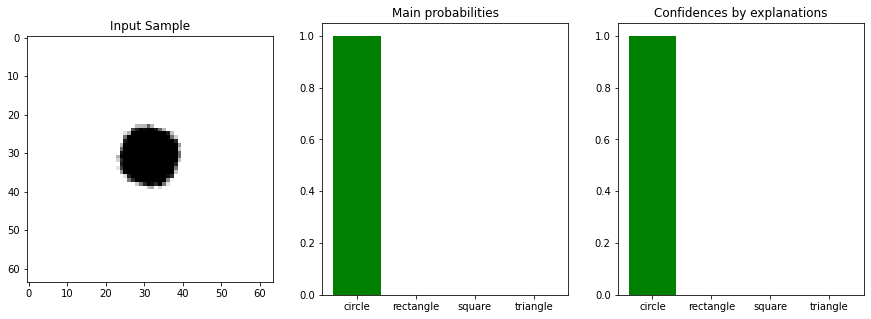

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


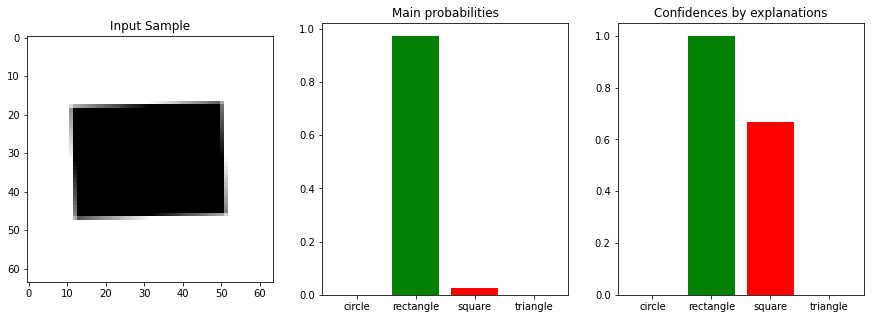

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


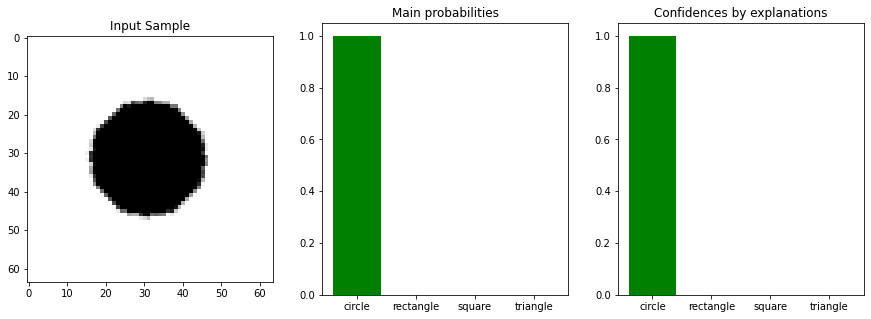

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


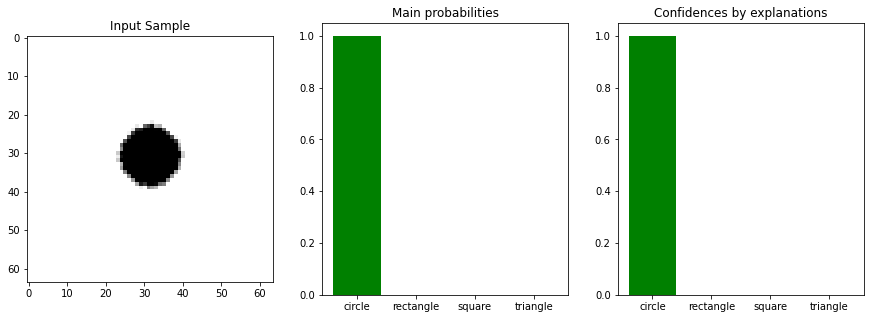

--------------------
True class: square
True explanations: [0 0 1 1 1]
Prediction by true explanations: [0.  1.  1.  0.5]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


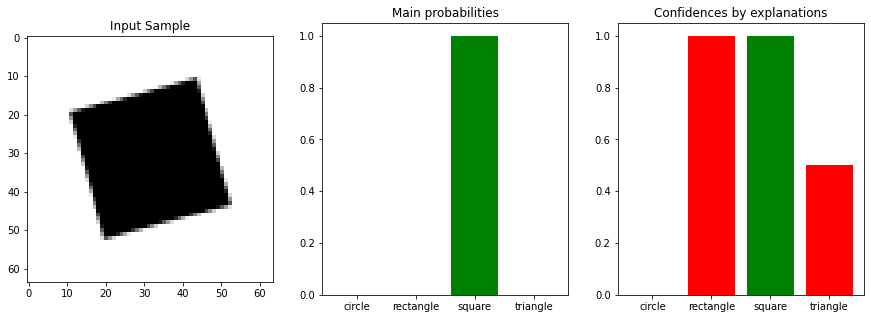

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


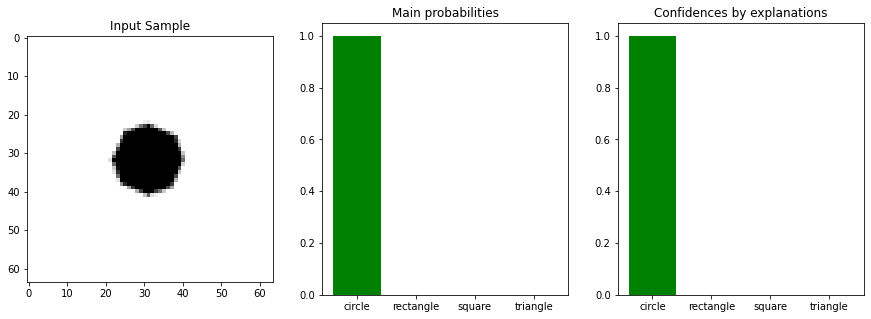

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: triangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


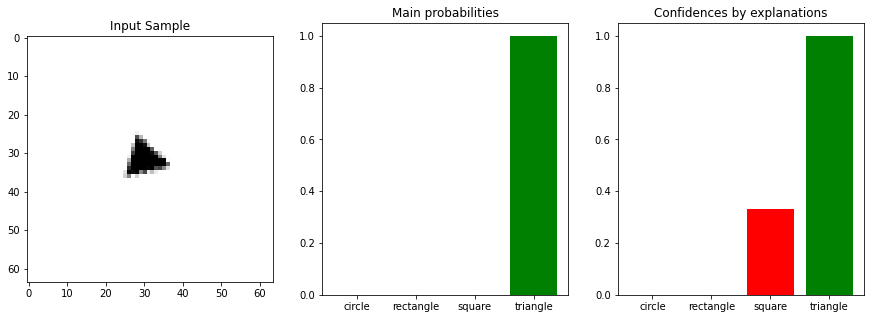

--------------------
True class: square
True explanations: [0 0 1 1 1]
Prediction by true explanations: [0.  1.  1.  0.5]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


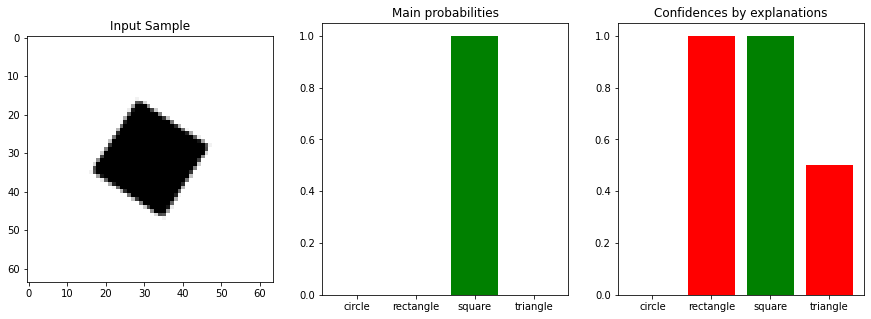

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: triangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


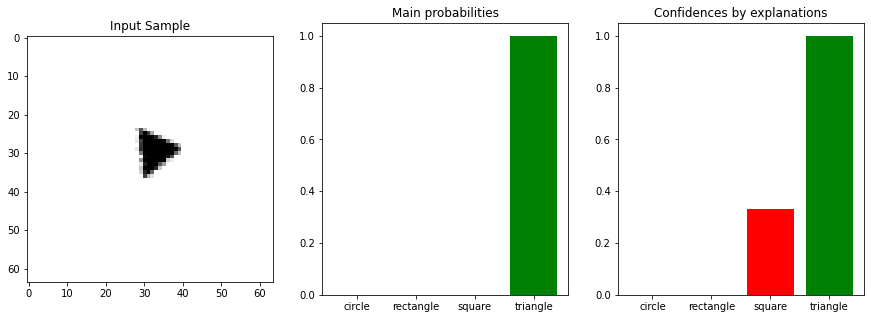

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: triangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


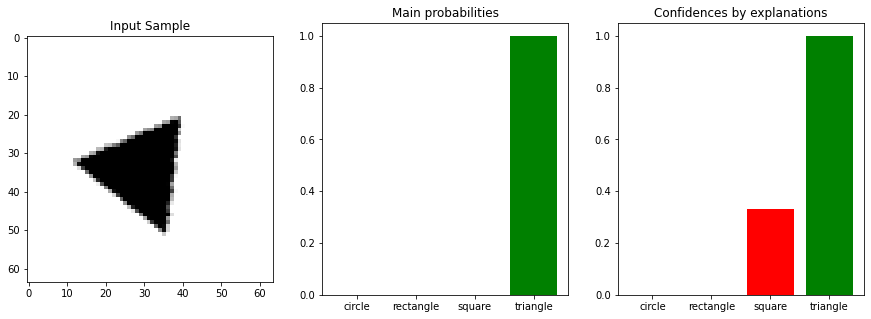

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


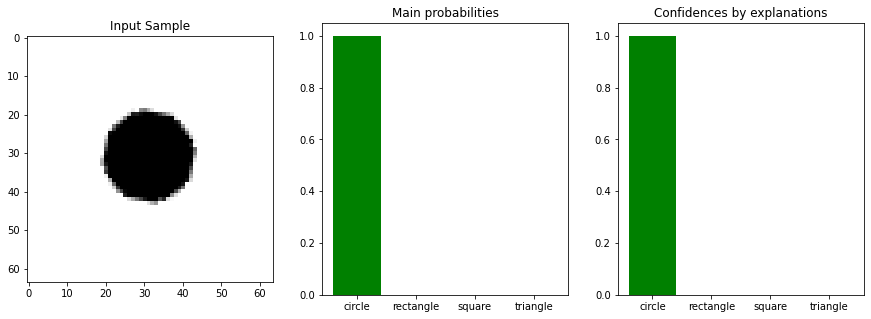

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


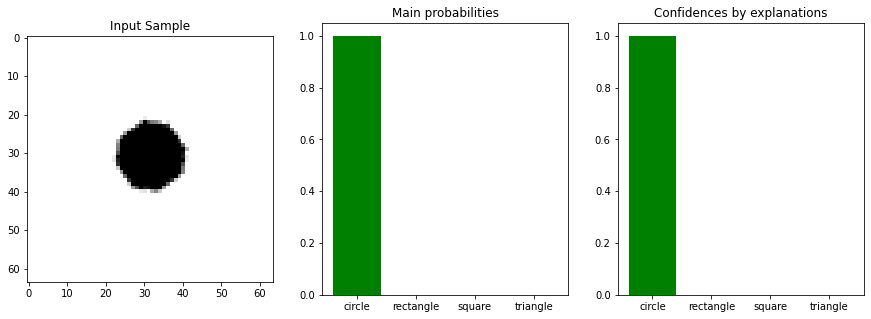

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


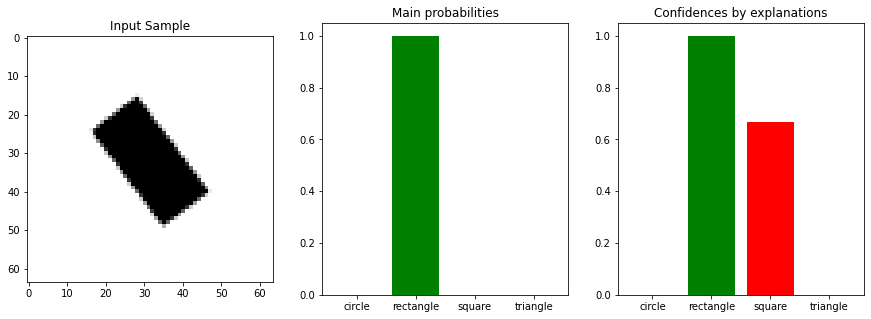

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: triangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


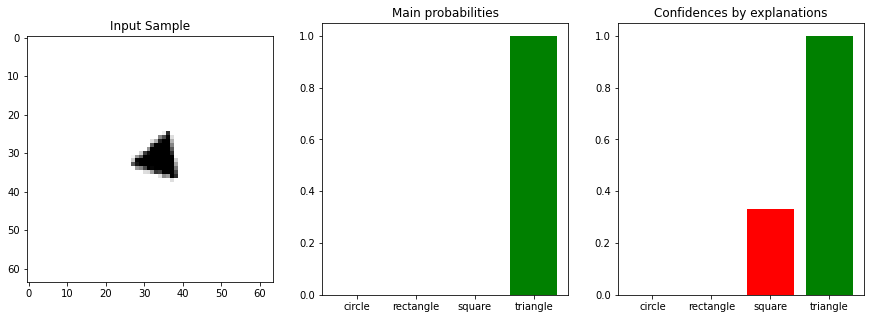

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


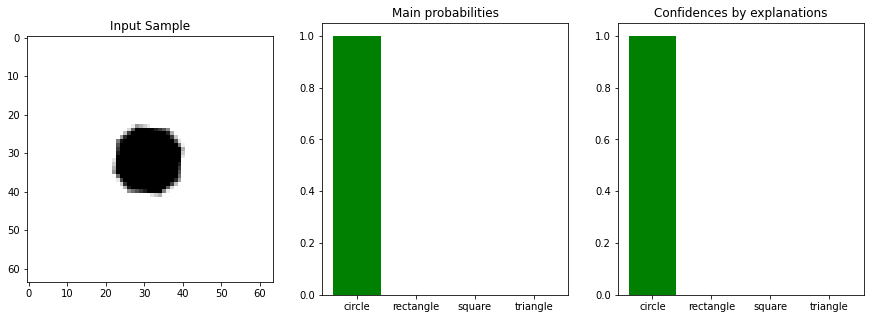

--------------------
True class: square
True explanations: [0 0 1 1 1]
Prediction by true explanations: [0.  1.  1.  0.5]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


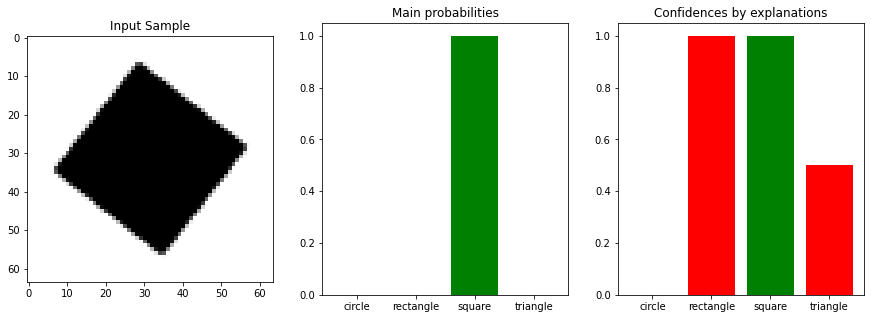

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


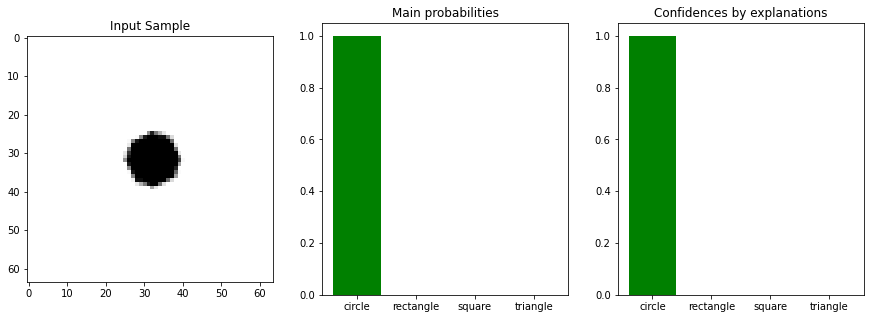

--------------------
True class: square
True explanations: [0 0 1 1 1]
Prediction by true explanations: [0.  1.  1.  0.5]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


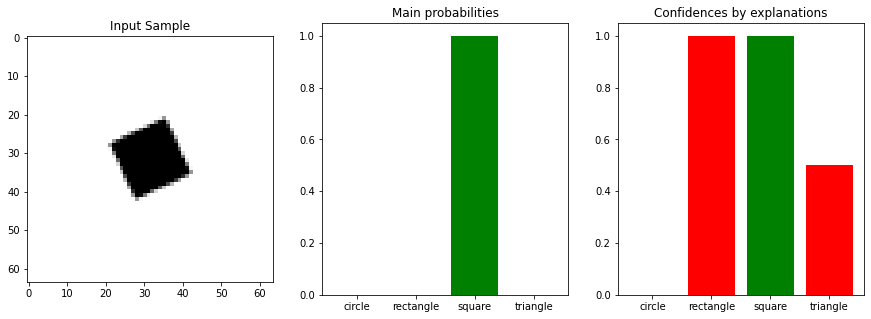

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: triangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


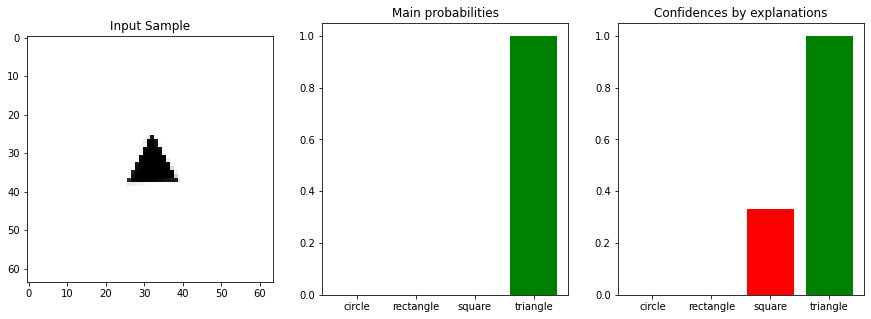

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


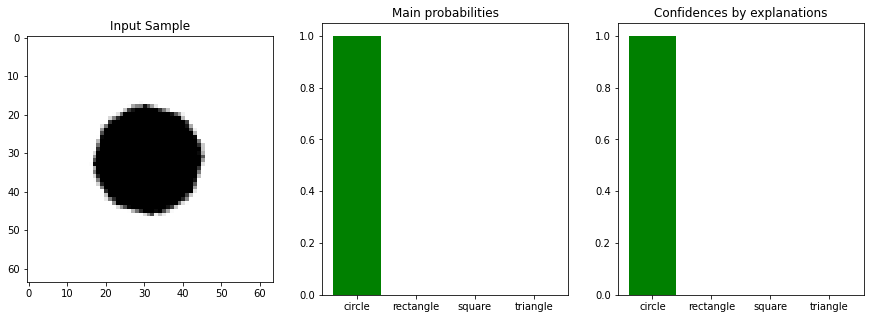

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


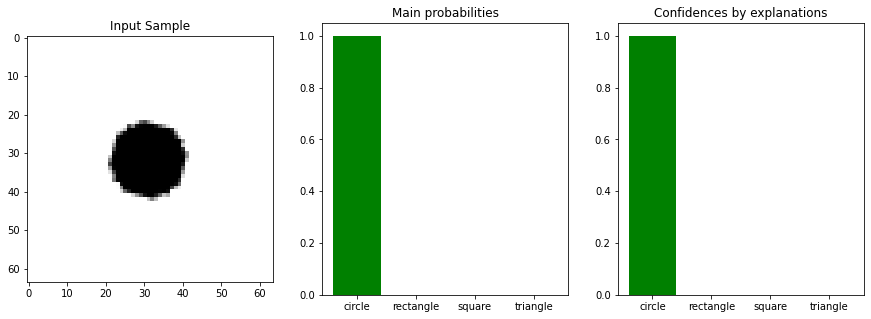

--------------------
True class: square
True explanations: [0 0 1 1 1]
Prediction by true explanations: [0.  1.  1.  0.5]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


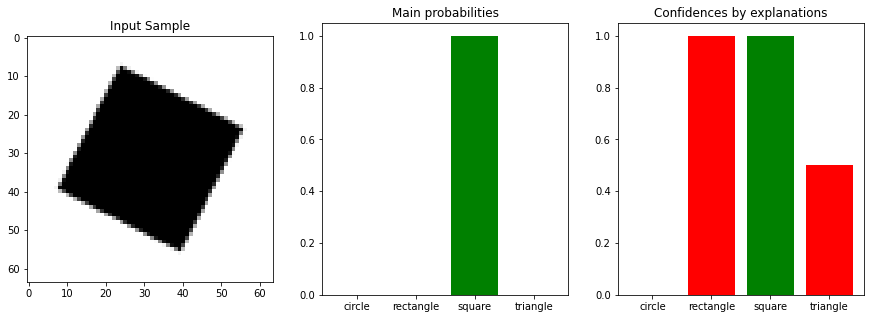

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


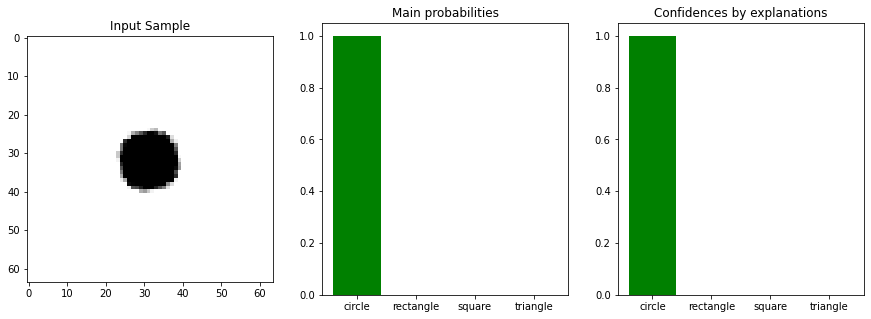

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


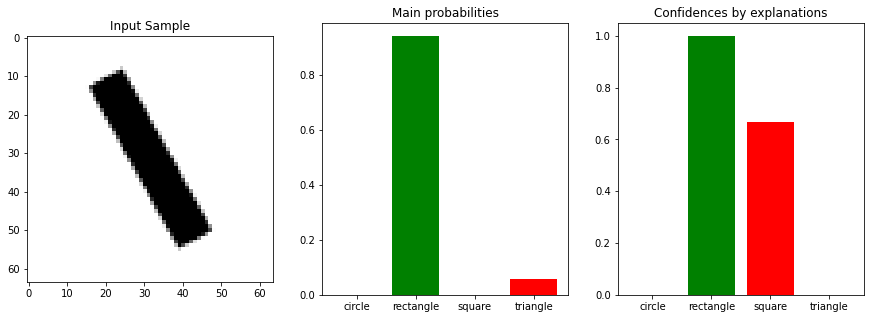

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: triangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


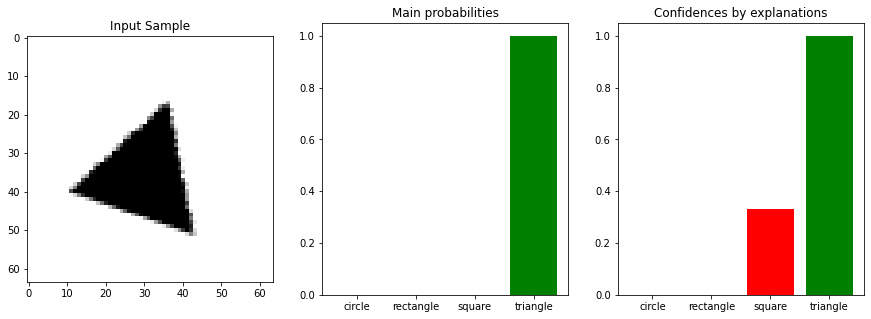

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


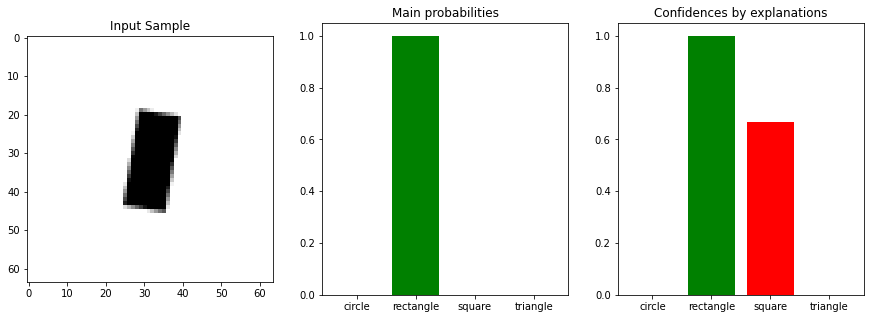

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


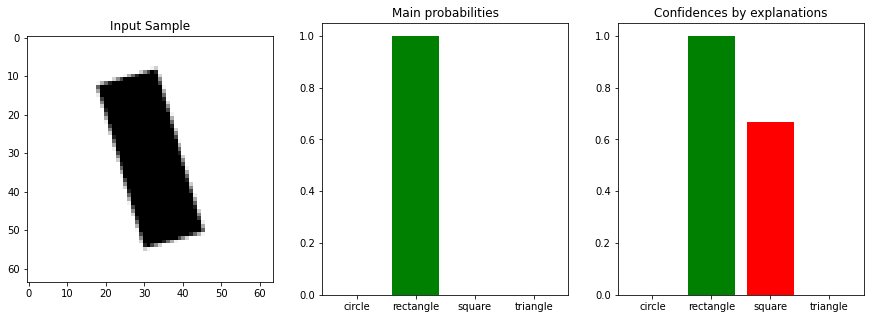

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: triangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


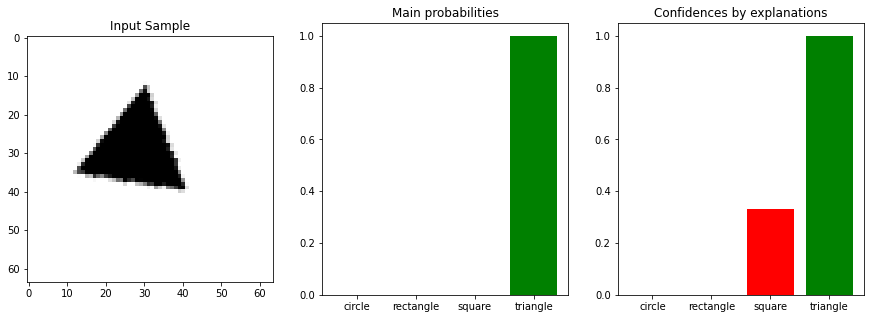

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


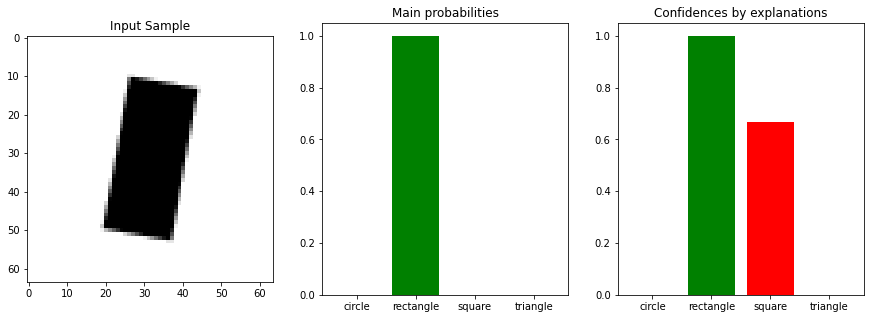

--------------------
True class: square
True explanations: [0 0 1 1 1]
Prediction by true explanations: [0.  1.  1.  0.5]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


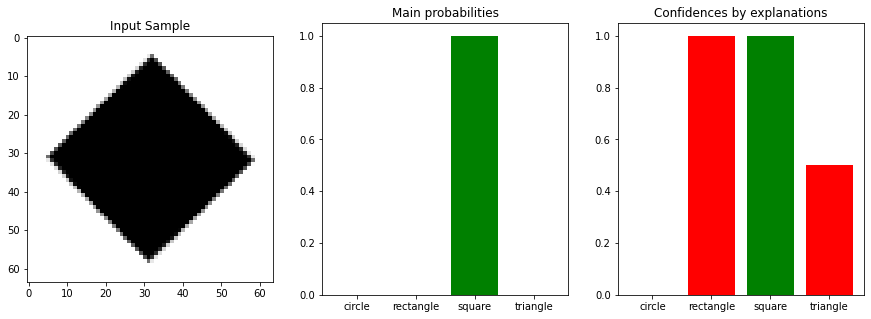

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


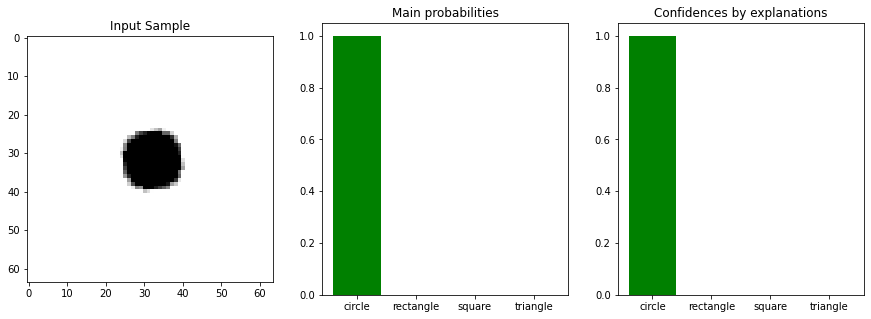

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: triangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


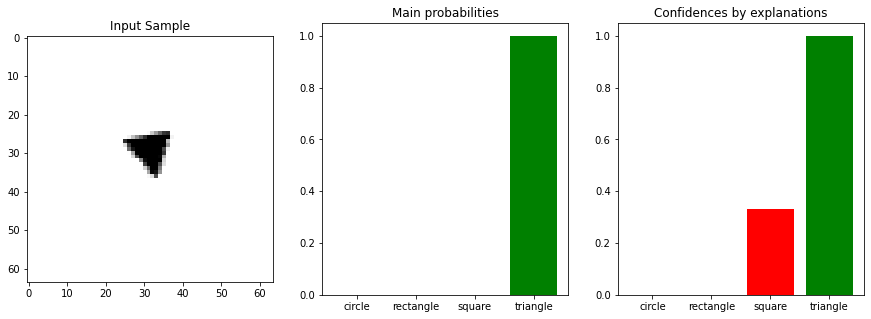

--------------------
True class: square
True explanations: [0 0 1 1 1]
Prediction by true explanations: [0.  1.  1.  0.5]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


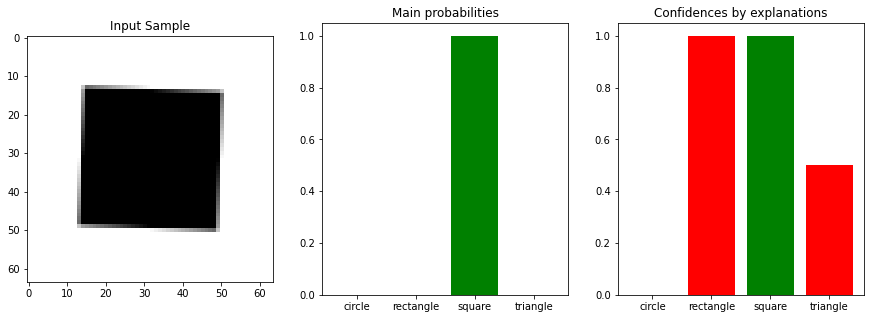

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


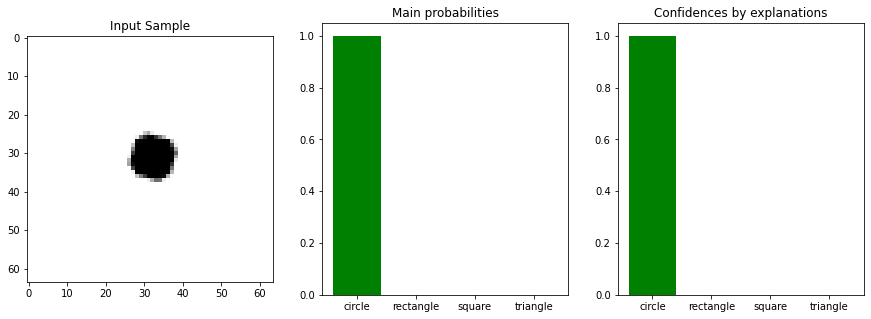

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: triangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


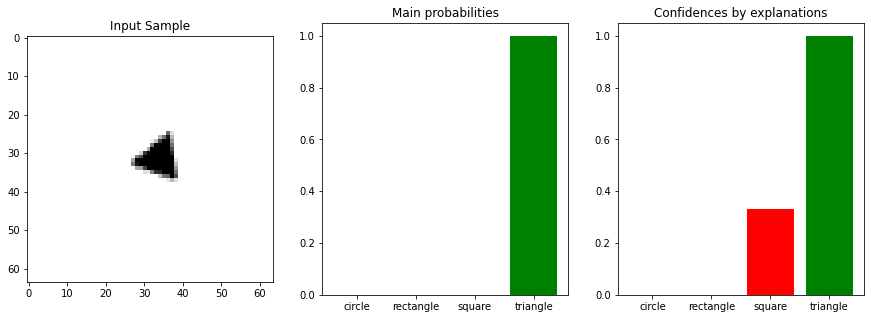

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: triangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


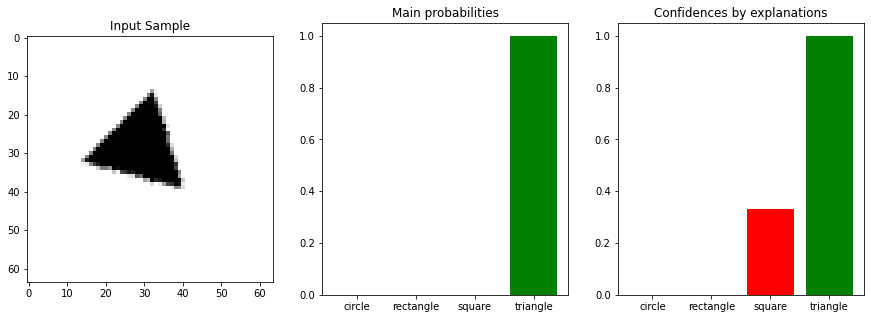

--------------------
True class: square
True explanations: [0 0 1 1 1]
Prediction by true explanations: [0.  1.  1.  0.5]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


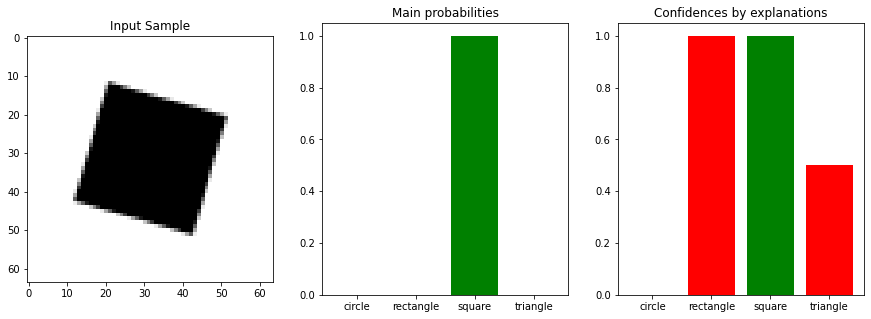

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


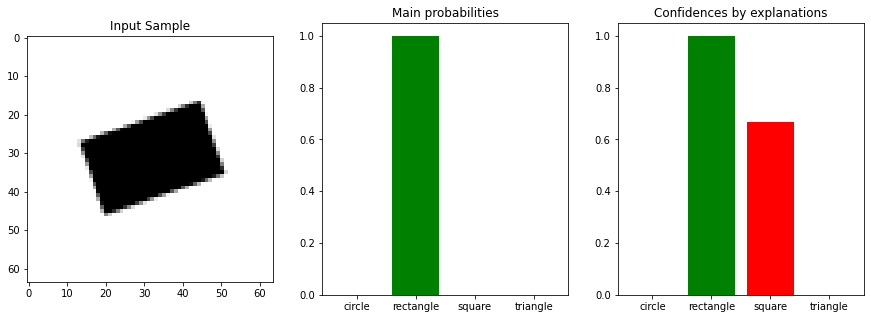

--------------------
True class: square
True explanations: [0 0 1 1 1]
Prediction by true explanations: [0.  1.  1.  0.5]
#######
Predicted class: square
Predicted explanations: [0 0 1 1 1]
Prediction by predicted explanations: [0.  1.  1.  0.5]


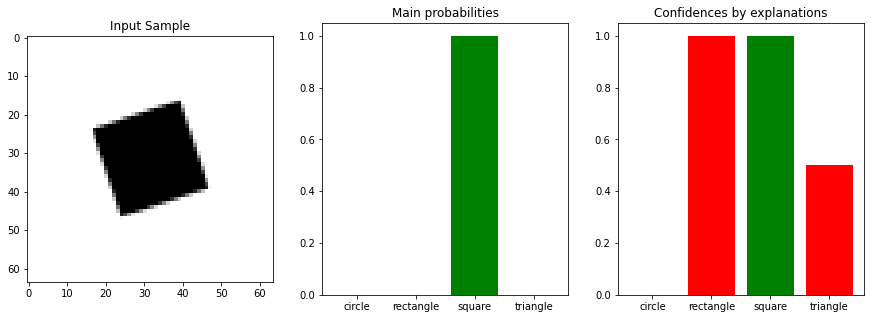

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


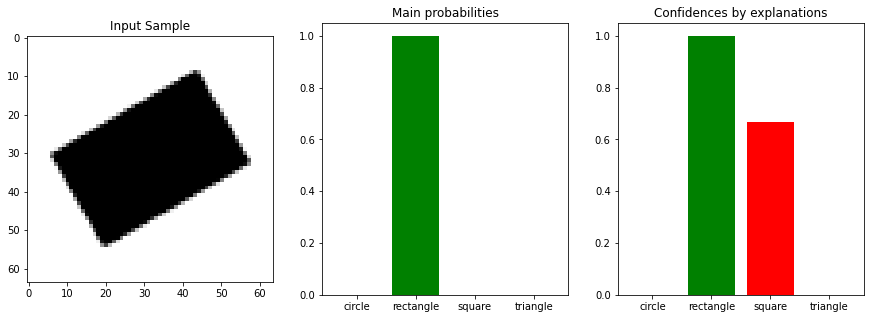

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: triangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


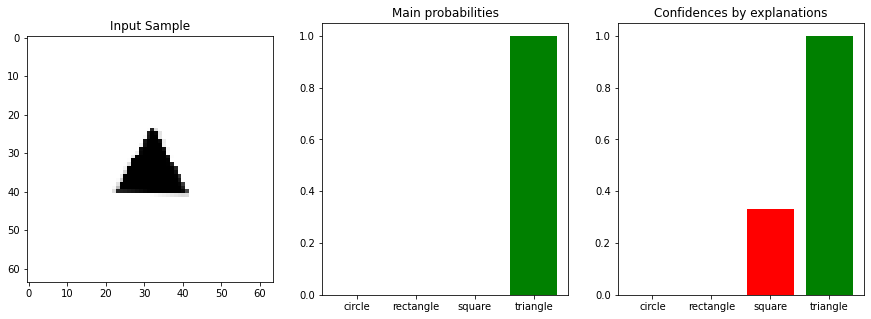

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: triangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


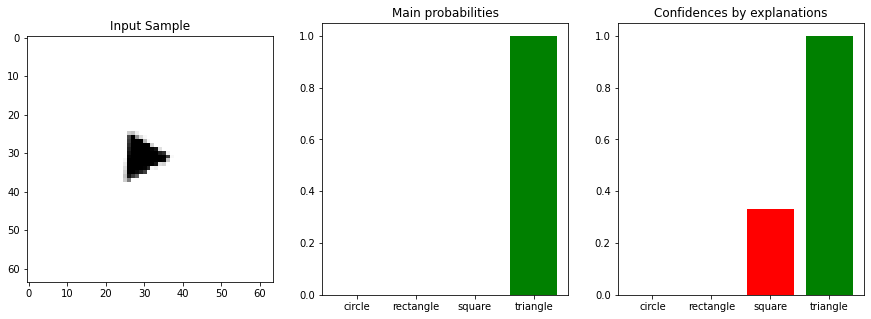

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


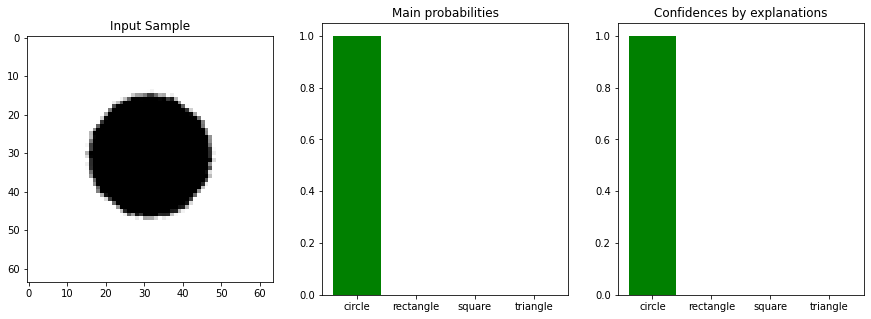

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


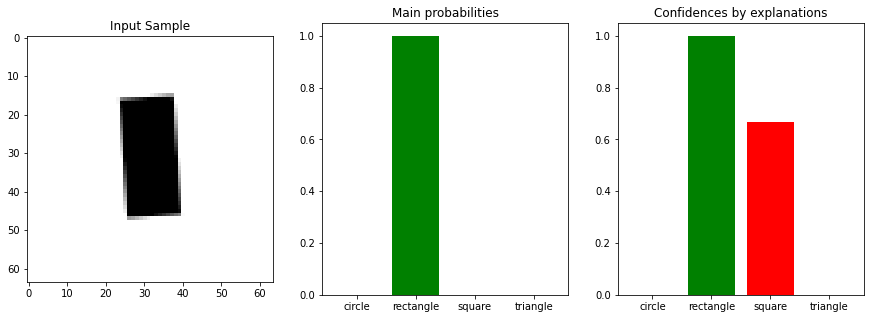

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


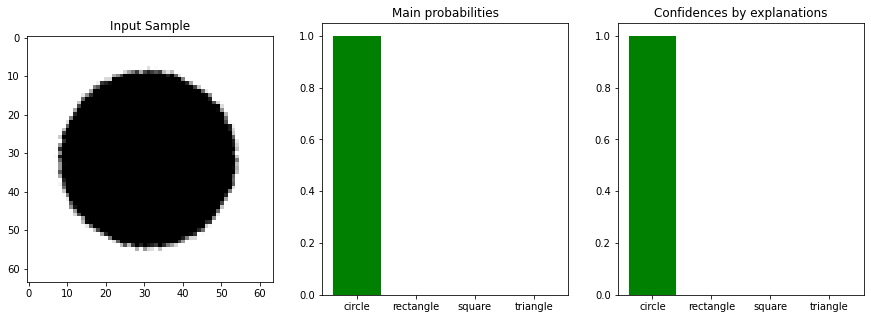

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


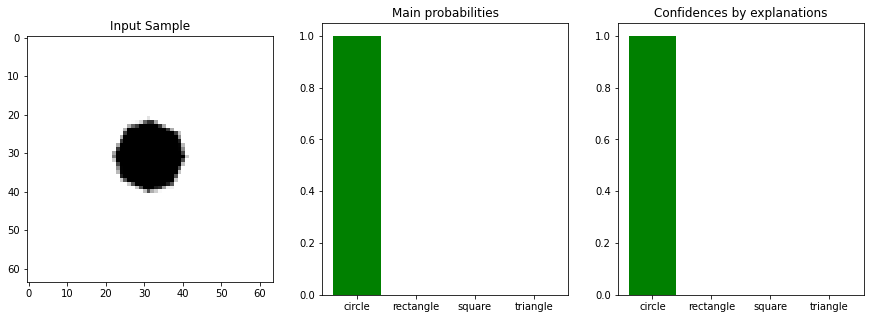

--------------------
True class: triangle
True explanations: [0 1 0 0 1]
Prediction by true explanations: [0.         0.         0.33333333 1.        ]
#######
Predicted class: triangle
Predicted explanations: [0 1 0 0 1]
Prediction by predicted explanations: [0.         0.         0.33333333 1.        ]


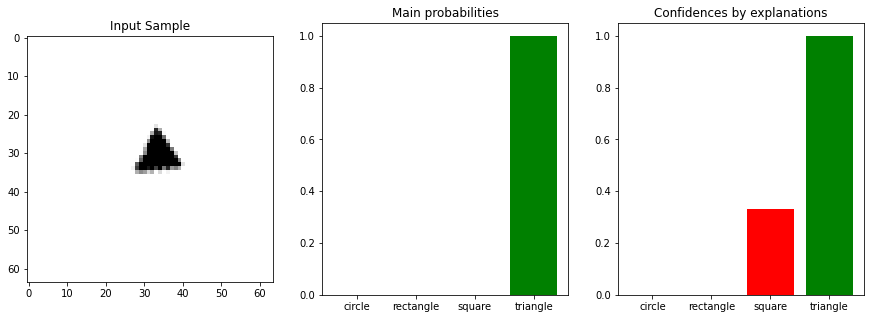

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


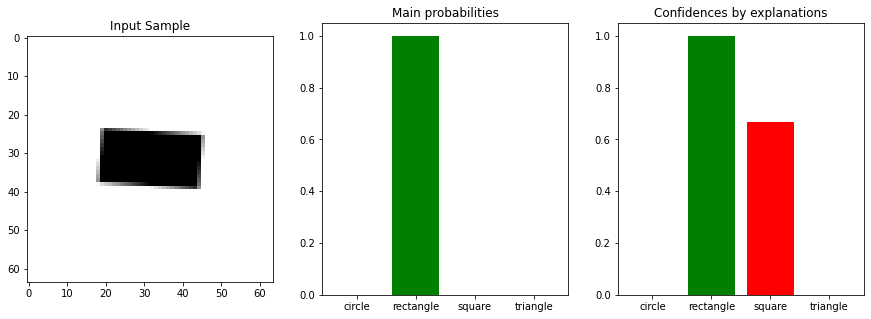

--------------------
True class: rectangle
True explanations: [0 0 1 1 0]
Prediction by true explanations: [0.         1.         0.66666667 0.        ]
#######
Predicted class: rectangle
Predicted explanations: [0 0 1 1 0]
Prediction by predicted explanations: [0.         1.         0.66666667 0.        ]


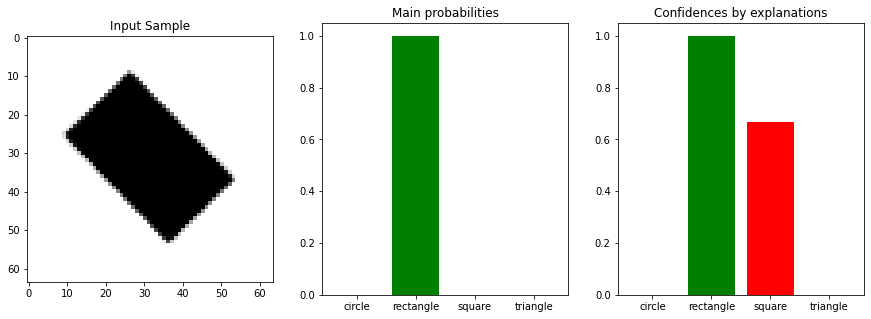

--------------------
True class: circle
True explanations: [1 0 0 0 0]
Prediction by true explanations: [1. 0. 0. 0.]
#######
Predicted class: circle
Predicted explanations: [1 0 0 0 0]
Prediction by predicted explanations: [1. 0. 0. 0.]


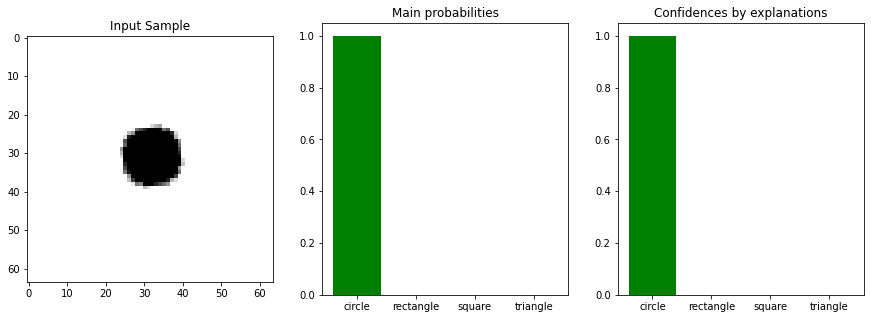

--------------------


In [76]:
for k in range(61):
    show_setex_correct_k(k, X_val, Y_val_classes, Y_val_pred_class, Y_expl_val, setex_expl_preds, main_correct_preds, prob_preds=setex_main_preds)

In [96]:
correct_cross_comparisons = 0
for k in range(main_correct_preds.shape[0]):
    correct_cross_comparisons += is_setex_correct_k(k, X_val, Y_val_classes, Y_val_pred_class, Y_expl_val, setex_expl_preds, main_correct_preds, prob_preds=setex_main_preds)

print(main_correct_preds.shape[0])
print(correct_cross_comparisons/main_correct_preds.shape[0])
print(1-correct_cross_comparisons/main_correct_preds.shape[0])

5939
0.998652971880788
0.001347028119211946


# OUT OF DISTRIBUTION EVALUATION

In [0]:
def show_setex_ood_k(k, X, Y_pred_classes, Y_pred_expl, prob_preds=None):
    mistake_img, pred_label = X[k], Y_pred_classes[k]
    pred_expl = Y_pred_expl[k]

    print('Predicted class:', lb.classes_[pred_label])
    print('Predicted explanations:', pred_expl)
    predictions_by_expl = predict_by_expl(pred_expl)
    print('Prediction by explanations:', predictions_by_expl)

    if prob_preds is not None:
        mistake_probs = prob_preds[k]
        print('Max probability:', np.max(mistake_probs))

        fig, axis = plt.subplots(1, 3, figsize=(15, 5))
        if mistake_img.shape[-1]==1:
            axis[0].imshow(np.squeeze(mistake_img), cmap='gray')
        else: axis[0].imshow(mistake_img)
        axis[1].bar(x=lb.classes_, height=mistake_probs)
        axis[2].bar(x=lb.classes_, height=predictions_by_expl)

        axis[0].set_title('Input Sample')
        axis[1].set_title('Main probabilities')
        axis[2].set_title('Confidences by explanations')
        plt.show()
    else:
        fig, axis = plt.subplots(1, 2, figsize=(10, 5))
        if mistake_img.shape[-1]==1: axis.imshow(np.squeeze(mistake_img), cmap='gray')
        else: axis[0].imshow(mistake_img)
        axis[1].bar(x=lb.classes_, height=predictions_by_expl)
        axis[0].set_title('Input Sample')
        axis[1].set_title('Confidences by explanations')
        plt.show()
    print('----------------------------------------')

In [0]:
ood_samples = 10
X_ood = np.random.rand(ood_samples, *input_shape)

setex_main_ood_preds, setex_expl_ood_preds = setex_model.predict(X_ood)
setex_expl_ood_preds = (setex_expl_ood_preds >= expl_threshold)*1

Y_ood_pred_classes = setex_main_ood_preds.argmax(axis=1)

Predicted class: triangle
Predicted explanations: [1 0 0 0 0]
Prediction by explanations: [1. 0. 0. 0.]
Max probability: 1.0


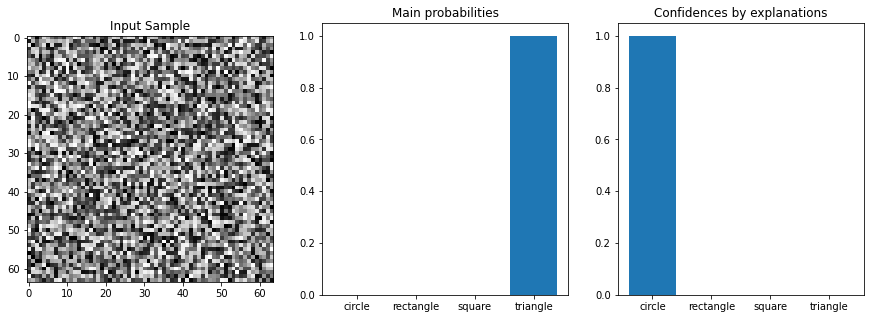

----------------------------------------
Predicted class: triangle
Predicted explanations: [1 0 0 0 0]
Prediction by explanations: [1. 0. 0. 0.]
Max probability: 0.999982


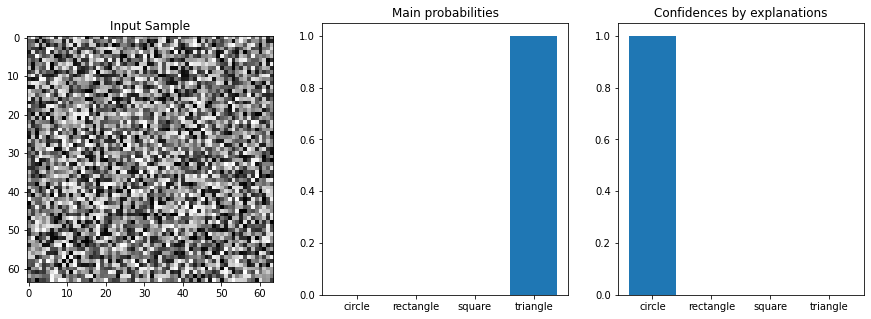

----------------------------------------
Predicted class: triangle
Predicted explanations: [0 0 1 1 1]
Prediction by explanations: [0.  1.  1.  0.5]
Max probability: 0.99999905


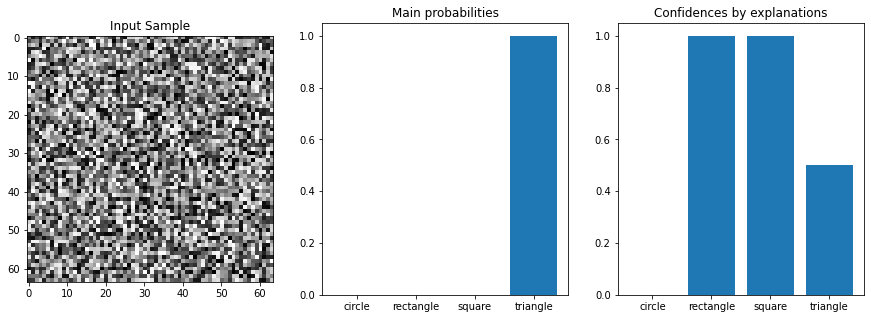

----------------------------------------
Predicted class: triangle
Predicted explanations: [0 0 1 1 0]
Prediction by explanations: [0.         1.         0.66666667 0.        ]
Max probability: 1.0


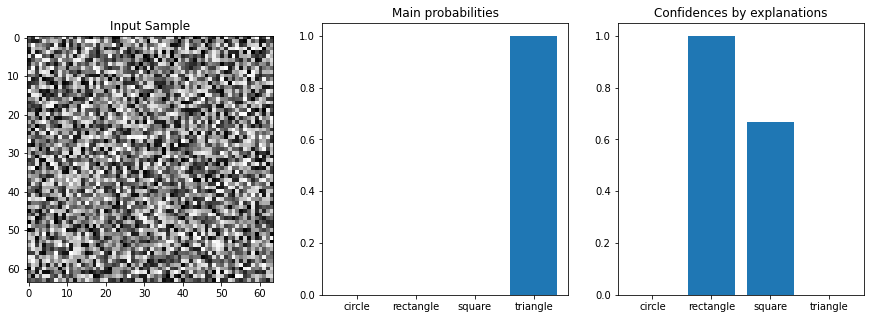

----------------------------------------
Predicted class: triangle
Predicted explanations: [0 1 0 0 1]
Prediction by explanations: [0.         0.         0.33333333 1.        ]
Max probability: 0.99983776


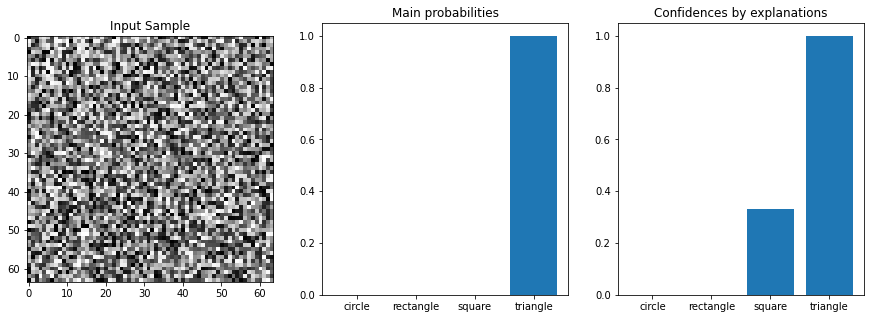

----------------------------------------
Predicted class: triangle
Predicted explanations: [0 0 1 1 1]
Prediction by explanations: [0.  1.  1.  0.5]
Max probability: 0.99621445


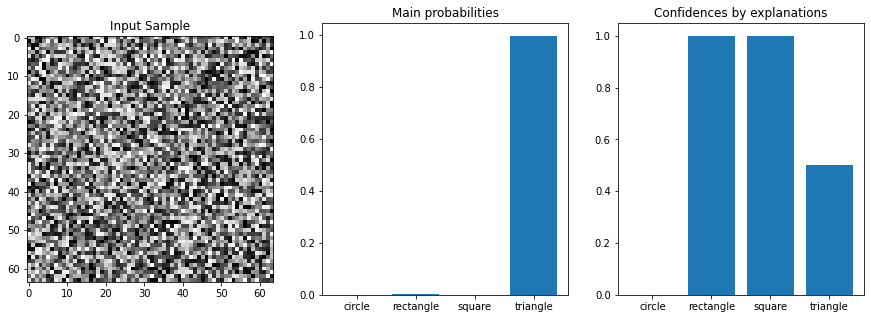

----------------------------------------
Predicted class: triangle
Predicted explanations: [1 0 0 0 0]
Prediction by explanations: [1. 0. 0. 0.]
Max probability: 0.99998844


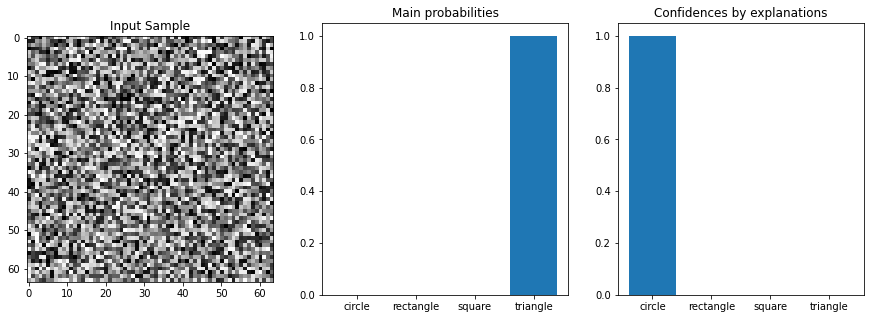

----------------------------------------
Predicted class: triangle
Predicted explanations: [0 1 0 0 1]
Prediction by explanations: [0.         0.         0.33333333 1.        ]
Max probability: 0.99999857


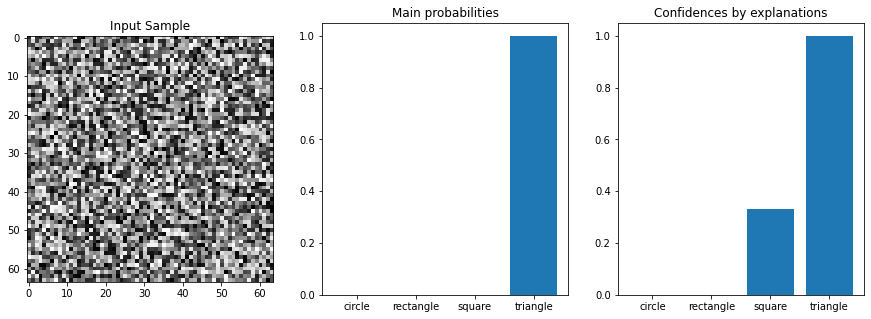

----------------------------------------
Predicted class: triangle
Predicted explanations: [1 0 1 1 0]
Prediction by explanations: [1.         1.         0.66666667 0.        ]
Max probability: 0.9999999


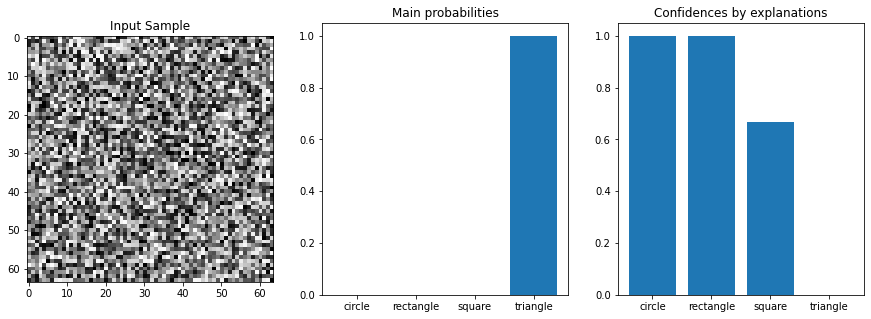

----------------------------------------
Predicted class: triangle
Predicted explanations: [1 0 0 0 0]
Prediction by explanations: [1. 0. 0. 0.]
Max probability: 0.9552555


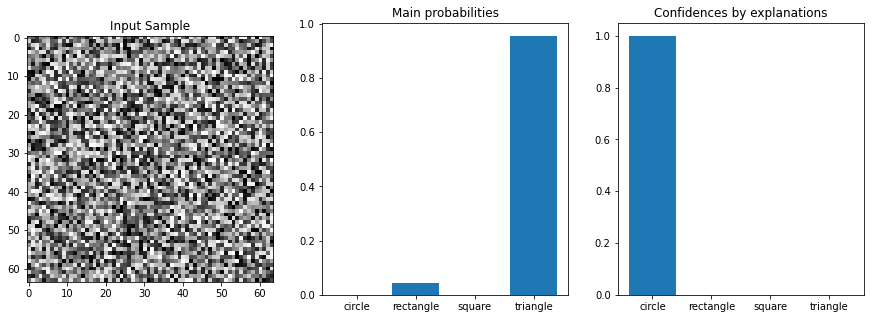

----------------------------------------


In [61]:
for k in range(10):
    show_setex_ood_k(k, X_ood, Y_ood_pred_classes, setex_expl_preds, prob_preds=setex_main_ood_preds)